# Capstone Project: Building a Movie Recommendation Engine

## 1) Problem Statement

The use of internet movie review databases such as RottenTomatoes.com and IMDB.com, have been extremely useful in helping movie viewers to decide if a particular film title is worth watching. However, as these resources are static in nature, the usefulness of such websites in providing potential film recommendations rely heavily on users actively searching and knowing what they are looking for.

Not only is this manual movie selection process uninteresting and repeative, more than often than not, movies which rate highly may not actually cater to the viewer's interests. For instance, a very highly rated science-fiction film that had won several Academy Awards, is likely to be passed over if the user is searching for a romantic comedy. Likewise, a user who constantly watches popular and highly-rated films, may lose the serendipidous discovery and enjoyment of new movie genres and unknown film titles.

To bridge this gap and provide an engaging customer experience, popular streaming providers like Youtube, Netflix and Amazon Videos have deployed machine learning algorithms to predict new video recommendations which their users may enjoy. Unfortunately, the use of such tools for movie recommendations are currently limited to: a) only their hosted video content, and b) for movies which have completed their theatrical release (i.e. no longer showing in cinemas).

As a movie fan who frequently goes to the cinema, the lack of any recommender system which includes both past and presently screening film titles leaves something to be desired. Therefore in this capstone project, I will be attempting to build a user personalized movie recommendation engine by incorporating each movie critic's review as explicit feedback. Finally, this model will be deployed online to allow for users to access the list of movie recommendations generated by this machine learning model.

## 2) Executive Summary
### Contents:
1) Problem Statement
<br>
2) Executive Summary
<br>
3) Importing the Libraries
<br>
4) Webscraping critic scores from RottenTomatoes.com
<br>
5) Data Cleaning
<br>
6) Data Supplementation
<br>
7) Exploratory Data Analysis (EDA)
<br>
8) Data Modelling
<br>
9) Model Tuning
<br>
10) Model Evaluation
<br>
11) Creating NMF Model Ver 2.0
<br>
12) Enrolling New Users
<br>
13) Populating our recsys_user dictionary with the RottenTomatoes critics
<br>
14) Final Testing
<br>
15) Model Deployment
<br>
16) Conclusion and Recommendations

## 3) Importing in the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import time
import re
from collections import defaultdict
import pickle
import random

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## 4) Webscraping critic scores from RottenTomatoes.com

For the project, the approach would be to assume each approved movie critic on RottenTomatoes.com as a single user within our movie recommendation database (aka. the "User"). For each movie critic, they would also have provided a movie rating score alongside the movie which they had watched (aka. the "Item"). By scraping the names of all movie critics and their relevant movie reviews/scores off RottenTomatoes.com, I will be attempting to create my database of verified users and their movie preferences.

### 4.1) Building a scraper to get each critic's URL link on RottenTomatoes.com

In [2]:
# Building an alphabet list of a-z ["a", "b", "c", ..... , "z"]

alpha_list = []
for i in range(ord('a'), ord('z')+1):
    alpha_list.append((chr(i)))

In [3]:
# Alphabet list is OK

alpha_list[:5]

['a', 'b', 'c', 'd', 'e']

In [4]:
# Building a list of urls to scroll through all the alphabets

alpha_url_list = []
for i in alpha_list:
    alpha_url_list.append(f"https://www.rottentomatoes.com/critics/authors?letter={i}")

In [5]:
# Alphabet URL list is OK

alpha_url_list[:2]

['https://www.rottentomatoes.com/critics/authors?letter=a',
 'https://www.rottentomatoes.com/critics/authors?letter=b']

In [6]:
# Function to get the critic's affiliation name

def get_affiliation(data):
    
    # Replace commas with @@@, applicable only to authors with multiple affiliations.
    # To allow for downstream separation
    step1 = data.get_text("@@@", strip=True)
       
    # Split the text into separate strings based on the "@@@"
    step2 = step1.split("@@@")
    
    # Getting the critic's affiliation
    if step2[0] == "Individually Approved":
        return "Individually Approved"
    elif step2 == "":
        return "Critic is not RT approved"
    else:
        return " ".join(step2[1:])

In [7]:
# Empty lists to store the data

critic_url_list = []
critic_name_list = []
critic_affiliation = []

### 4.2) Scraping the list of author names from RottenTomatoes.com
- This scraping was performed outside of Jupyter notebook

```python
# Cycles through the 26 pages of authors based on their last_names a-z

for i in alpha_url_list:  
    
    # Gets the current alphabet's page and convert to soup object
    # Create random User-Agent as random integer from 100-999
    headers = {'User-Agent': str(np.random.randint(100,999))}
    res = requests.get(i, headers=headers)
    soup = BeautifulSoup(res.content, "lxml")
    
    # For every critic, store their name, URL
    for link in soup.find_all(class_=f"a critic-authors__name"):
        if link == "":
            break
        else:
            critic_url_list.append(link.get("href"))
            critic_name_list.append(link.get_text())
    
    # For every critic, store their affiliation
    for affiliate in soup.find_all("span", class_="rt-font-frank-book rt-font-s"):
        
        # There are no critics with last-name starting with X. Therefore:
        if affiliate.get_text() == "No critics available. Please try another option.":
            break
        else:
            critic_affiliation.append(get_affiliation(affiliate))
    print(i)
```

In [8]:
# 4319 critics (as of Dec 19)
# Commented out as above block of code is not run

# len(critic_url_list)   

In [9]:
# 4319 critics (as of Dec 19)
# Commented out as above block of code is not run

# len(critic_name_list)

In [10]:
# 4319 critics (as of Dec 19)
# Commented out as above block of code is not run

# len(critic_affiliation)

In [11]:
# Convert critic details into a dataframe

# rt_critic_details = pd.DataFrame({"critic_name": critic_name_list,
#                                   "critic_affiliation": critic_affiliation,
#                                   "critic_rt_url": critic_url_list
#                                   })

In [12]:
# The format of critic details looks alright

# rt_critic_details.head()

In [13]:
# Saving the dataframe into CSV
# COMMENTED OUT DUE TO SAFETY REASONS

# rt_critic_details.to_csv("./datasets/rt_critic_details.csv")

### 4.3) Setting up functions to assist in the scraping, using each critic's unique URL

In [14]:
# Reading in the critic name list dataframe

rt_critic_details = pd.read_csv("./datasets/rt_critic_details.csv").drop(columns="Unnamed: 0")

In [15]:
rt_critic_details.head()

,critic_name,critic_affiliation,critic_rt_url
0,Josefine A.,One Room With A View,/critic/josefine-a
1,Lysalex Hernández A.,La Nación (Costa Rica),/critic/lysalex-hernandez-a
2,Alex Abad-Santos,Vox,/critic/alex-abad-santos
3,Kate Abbott,Guardian,/critic/kate-abbott
4,Alana Joli Abbott,Den of Geek,/critic/alana-joli-abbott


In [16]:
rt_critic_details[["critic_rt_url"]].head()

,critic_rt_url
0,/critic/josefine-a
1,/critic/lysalex-hernandez-a
2,/critic/alex-abad-santos
3,/critic/kate-abbott
4,/critic/alana-joli-abbott


#### 4.3.1) Creating a function to extract the movie title and the year released

In [17]:
def movie_year_review(data):
    
    # Get the object from Soup.
    # "title_years" are from even indexes
    # "reviews" are from odd indexes
    
    title_year_review = soup.find_all("td", {"class": ["col-xs-12 col-sm-6 critic-review-table__title-column",
                                                       "col-sm-12 responsive-table__full-width-column"]})[data]
    # Getting the "title_years"
    step1 = title_year_review.get_text("@@@", strip=True)
    
    # Split the text into separate strings based on the "@@@"
    step2 = step1.split("@@@")
    
    # Getting the movie title and movie release year (even indexes)
    if (len(step2) == 2) and (data % 2 == 0):
        movie_title = step2[0]
        movie_release_year = step2[1]
        return movie_title, movie_release_year   # returns a tuple
    
    elif (len(step2) == 1) and (data % 2 == 0):   # introduced to solve instances where titles do not have years
        movie_title = step2[0]
        movie_release_year = "(Year Unknown)"
        return movie_title, movie_release_year   # returns a tuple
    
    # Getting the movie review, publication location, and review data
    else:
        movie_review = step2[0]         # movie_review is the first_index
        review_location = step2[1][2:]  # publication location is the second index, skip first 2 char for formatting
        review_date = step2[-1][9:]     # publication date is the last index, skip first 9 char for formatting
        return movie_review, review_location, review_date   # returns a tuple

#### 4.3.2) Creating empty lists to temporarily hold the scraped data

In [18]:
# Getting the number of RT critics

num_of_critics = len(rt_critic_details.index)
num_of_critics

4319

In [19]:
# Empty lists to store data

# Critic's names/affiliations
critic_name = []
critic_affiliation = [] 
critic_rt_url = []

# Critic's movie review details
critic_score = []
rt_score = []
title = []
year_released = []
movie_review = []
review_pub_loc = []
review_pub_date = []

### 4.4) The actual scraping of critic review scores from RottenTomatoes.com
- This scraping was performed outside of Jupyter notebook (as of 13 Dec 2019)

```python
# For loop to collect each movie critic's movie reviews

for current_index in range(0,100):
    
    critic_url = rt_critic_details["critic_rt_url"][current_index]   # For each row index, get the critic_url
    headers = {'User-Agent': str(np.random.randint(10000,99999))}   # Randomize User-Agent
    
    for page in range(1,999):
        res = requests.get(f"https://www.rottentomatoes.com{critic_url}/movies?page={page}", headers=headers)
        soup = BeautifulSoup(res.content, "lxml")

        # If page is empty, break the loop (i.e end of critic's review page)
        if soup.find_all("td",  {"class": "col-xs-6 col-sm-3"}) == []:
            break
    
        # If page is on a TV review, break the loop (i.e display name does not have the string "Movie")
        if soup.find("a",  {"data-display-name": "Movie"}) == None:
            break

        # If page is filled, proceed to scrape
        else:
            # Calculating how many reviews on the page
            review_length = len(soup.find_all("td",  {"class": "col-xs-6 col-sm-3"}))

            # Looping through the reviews
            for i in range(review_length):

                # Even number indexes give the critic review score
                if i % 2 == 0:
                    
                    # If no score is given in the review, append "No_score_given"
                    if soup.find_all("td", {"class": "col-xs-6 col-sm-3"})[i].get_text().strip() == "":
                        critic_score.append("No_score_given")
                    
                        # Appending critic's information into this row
                        critic_name.append(rt_critic_details["critic_name"][current_index])
                        critic_affiliation.append(rt_critic_details["critic_affiliation"][current_index])
                        critic_rt_url.append(critic_url)                   

                    else:
                        critic_score.append(soup.find_all("td", {"class": "col-xs-6 col-sm-3"})[i].get_text().strip())
                    
                        # Appending critic's information into this row
                        critic_name.append(rt_critic_details["critic_name"][current_index])
                        critic_affiliation.append(rt_critic_details["critic_affiliation"][current_index])
                        critic_rt_url.append(critic_url)    

                # Odd number indexes give us the RT composite score
                else:
                    rt_score.append(soup.find_all("td",
                                                  {"class": "col-xs-6 col-sm-3"})[i].get_text().strip())
        
            # For each critic, obtain the movie title and movie release year.
            # As this is a new index, a new for-loop is needed
            # Getting the number of 
            movie_review_number = len(soup.find_all("td",
                                                {"class": ["col-xs-12 col-sm-6 critic-review-table__title-column",
                                                            "col-sm-12 responsive-table__full-width-column"]}))

            for j in range(movie_review_number):

                # Using the movie_year function, this is an even-number index
                if j % 2 == 0:
                    title.append(movie_year_review(j)[0])
                    year_released.append(movie_year_review(j)[1][1:5])   # [1:5] to remove round brackets

                # Using the movie_review function, this is an odd-number index
                else:
                    movie_review.append(movie_year_review(j)[0])
                    review_pub_loc.append(movie_year_review(j)[1])
                    review_pub_date.append(movie_year_review(j)[2])

    # Random sleep timing
    num = np.random.randint(5,30)
    time.sleep(num)
      
    # Display the status
    if current_index % 10 == 0:
        print(f"The current index is {current_index}. {len(critic_score)} reviews and {len(title)} titles scraped")

```

### 4.5) Rearranging and saving the critic review dataframe

In [20]:
# Combining the lists into a DataFrame

df_rt = pd.DataFrame({"critic_name": critic_name,
                      "critic_affiliation": critic_affiliation,
                      "critic_rt_url": critic_rt_url,
                      "critic_score": critic_score,
                      "rt_score": rt_score,
                      "title": title,
                      "year_released": year_released,
                      "movie_review": movie_review,
                      "review_pub_loc": review_pub_loc,
                      "review_pub_date": review_pub_date})

In [21]:
# Saving the dataframe into CSV
# COMMENTED OUT DUE TO SAFETY REASONS

# df_rt.to_csv("./datasets/rt_reviews_list_all.csv")

## 5) Data Cleaning
- Here, missing data will be filled in or removed, depending on how salvagable they are.

In [22]:
# Read to CSV

df_rt = pd.read_csv("./datasets/rt_reviews_list_all.csv").drop(columns="Unnamed: 0")

In [23]:
df_rt.head(3)

,critic_name,critic_affiliation,critic_rt_url,critic_score,rt_score,title,year_released,movie_review,review_pub_loc,review_pub_date
0,Josefine A.,One Room With A View,/critic/josefine-a,3/5,89%,Bacurau (Nighthawk),2019,"With a set up as large as this, Bacurau would ...",One Room With A View,"Jul 8, 2019"
1,Josefine A.,One Room With A View,/critic/josefine-a,3/5,67%,The Extraordinary Journey of Celeste Garcia (E...,2018,Celeste García is a truly original and affecti...,One Room With A View,"Jul 8, 2019"
2,Josefine A.,One Room With A View,/critic/josefine-a,4/5,No Score Yet,Insumisas,2019,The script by writer-director team Fernando Pe...,One Room With A View,"Jul 5, 2019"


In [24]:
df_rt.shape

(777565, 10)

In [25]:
# Checking for missing values

df_rt.isnull().sum()

critic_name              0
critic_affiliation      90
critic_rt_url            0
critic_score             0
rt_score                 0
title                 1458
year_released            0
movie_review             0
review_pub_loc           0
review_pub_date          0
dtype: int64

### 5.1) Removing critics without any validated affiliation

In [26]:
missing_critic_affiliation = df_rt[df_rt["critic_affiliation"].isnull()]
df_rt = df_rt.drop(missing_critic_affiliation.index, axis=0)

In [27]:
# Checking the new shape, missing critic_affiliations have been dropped

df_rt.shape

(777475, 10)

### 5.2) Removing reviews without any movie titles

In [28]:
# Removing missing values from title

missing_title = df_rt[df_rt["title"].isnull()]
df_rt = df_rt.drop(missing_title.index, axis=0)

In [29]:
# Checking the new shape, missing titles have been dropped

df_rt.shape

(776017, 10)

### 5.3) Removing movie reviews that do not have any proper "year_released" values

In [30]:
# Some rows in the "year_released" columns have the string "year" instead of an actual year value

df_rt["year_released"].unique()

array(['2019', '2018', '2017', '2016', '2015', '2013', '2011', '2014',
       '2012', '2010', '2009', '2008', '2007', '2006', '2005', '2004',
       '2003', '2001', '2002', '2000', '2020', '1974', '1966', '1981',
       '1978', '1990', '1979', '1934', '1977', '1948', '1964', '1954',
       '1960', '1994', '1991', '1999', '1975', '1968', '1985', '1969',
       '1970', '1982', '1973', '1971', '1967', '1976', '1984', '1983',
       '1986', '1997', '1957', '1927', '1931', '1955', '1965', '1972',
       '1951', '1998', '1988', '1944', '1995', '1980', '1958', '1961',
       '1937', '1939', '1945', '1953', '1992', '1989', '1987', '1993',
       '1924', '1938', '1963', '1935', '1956', '1959', '1941', '1996',
       'Year', '1952', '1950', '1949', '1943', '1932', '1962', '1936',
       '1929', '1928', '1940', '1933', '1921', '1915', '1930', '1919',
       '1947', '1920', '1946', '1902', '1925', '1914', '1913', '1926',
       '1942', '1922', '1923', '1899', '1916', '1917', '1918', '1910',
      

In [31]:
# There are 76 rows in the feature"year_released" without a year value
# There rows will be removed

wrong_year = df_rt[df_rt["year_released"] == "Year"]
df_rt = df_rt.drop(wrong_year.index, axis=0)

In [32]:
# The 76 rows with wrong year values have been removed

df_rt.shape

(775941, 10)

### 5.4) Converting "year_released" into an integer format

In [33]:
df_rt["year_released"] = df_rt["year_released"].astype(int)

In [34]:
# "year_released" successfully converted from string to integer format

df_rt["year_released"][:5]

0    2019
1    2018
2    2019
3    2019
4    2019
Name: year_released, dtype: int64

### 5.5) Correcting "review_pub_date" rows with wrong values

In [35]:
# There are rows with the string "Invalid date" within the "review_pub_date" feature (see rightmost column)

wrong_review_dates = df_rt[df_rt["review_pub_date"] == "Invalid date"]
wrong_review_dates.head()

,critic_name,critic_affiliation,critic_rt_url,critic_score,rt_score,title,year_released,movie_review,review_pub_loc,review_pub_date
23108,Jason Anderson,Individually Approved,/critic/jason-anderson,3/4,No Score Yet,Invisible City,2009,- Toronto Star,IT,Invalid date
23109,Jason Anderson,Individually Approved,/critic/jason-anderson,3/4,No Score Yet,Machotaildrop,2009,- Toronto Star,IT,Invalid date
23110,Jason Anderson,Individually Approved,/critic/jason-anderson,2/5,40%,Gunless,2011,Gunless is certainly eager to please. Yet for ...,eye WEEKLY,Invalid date
35055,Jason Bailey,Individually Approved,/critic/jason-bailey,No_score_given,No Score Yet,Visionaries,2010,The avant-garde filmmakers joined forces to cr...,DVDTalk.com,Invalid date
35056,Jason Bailey,Individually Approved,/critic/jason-bailey,No_score_given,60%,Vidal Sassoon: The Movie,2011,"A bright, cheery pop confection, the entertain...",DVDTalk.com,Invalid date


In [36]:
# There are 44 such error rows. These will be removed.

wrong_review_dates.shape

(44, 10)

In [37]:
# Dropping the rows with invalid date entries

df_rt = df_rt.drop(wrong_review_dates.index, axis=0)

In [38]:
# These 44 error rows have been removed

df_rt.shape

(775897, 10)

### 5.6) Converting "review_pub_date" into datetime format

In [39]:
# Converting into datetime format

df_rt["review_pub_date"] = pd.to_datetime(df_rt["review_pub_date"])

In [40]:
# All formats have been successfully converted

df_rt.dtypes

critic_name                   object
critic_affiliation            object
critic_rt_url                 object
critic_score                  object
rt_score                      object
title                         object
year_released                  int64
movie_review                  object
review_pub_loc                object
review_pub_date       datetime64[ns]
dtype: object

### 5.7) Number of unique movie titles in our dataset
- There are 49237 unique movie titles in our Rotten Tomatoes dataset

In [41]:
# There are 49237 unique movie titles

len(df_rt["title"].unique())

49237

In [42]:
list_of_titles = df_rt["title"].unique()

In [43]:
list_of_titles[:10]

array(['Bacurau (Nighthawk)',
       'The Extraordinary Journey of Celeste Garcia (El viaje extraordinario de Celeste García)',
       'Insumisas', 'Vita & Virginia', 'This is not Berlin',
       'Golden Youth (Une jeunesse dorée)', 'Destination Wedding',
       'Woman at War (Kona fer í stríð)', 'Hannah',
       'Bombshell: The Hedy Lamarr Story'], dtype=object)

### 5.8) Concatenating "title" and "year_released" into a new feature "title_year" in our RottenTomatoes dataset.
- As there are many movies with the same title, joining the movie "title" with its "year_released" will allow for its accurate identification.
- The "title" feature will be concatenated with "year_released" into a new engineered feature "title_year".

In [44]:
# Creating a new feature "title_year" in our RottenTomatoes dataset

df_rt["title_year"] = df_rt["title"].astype(str) + " (" + df_rt["year_released"].astype(str) + ")"

In [45]:
# A new "title_year" feature has been generated (see right-most column)

df_rt.head(3)

,critic_name,critic_affiliation,critic_rt_url,critic_score,rt_score,title,year_released,movie_review,review_pub_loc,review_pub_date,title_year
0,Josefine A.,One Room With A View,/critic/josefine-a,3/5,89%,Bacurau (Nighthawk),2019,"With a set up as large as this, Bacurau would ...",One Room With A View,2019-07-08,Bacurau (Nighthawk) (2019)
1,Josefine A.,One Room With A View,/critic/josefine-a,3/5,67%,The Extraordinary Journey of Celeste Garcia (E...,2018,Celeste García is a truly original and affecti...,One Room With A View,2019-07-08,The Extraordinary Journey of Celeste Garcia (E...
2,Josefine A.,One Room With A View,/critic/josefine-a,4/5,No Score Yet,Insumisas,2019,The script by writer-director team Fernando Pe...,One Room With A View,2019-07-05,Insumisas (2019)


### 5.9) Inspecting our movie critic's scores
- Due to the variety of movie score rating scales, all of these values have to be normalized if any comparison between them are to be made.
- In cases where the scale cannot be determined, they have to be deleted.

In [46]:
df_rt["critic_score"].unique()[:100]   # Showing the first 100 unique types of scores

array(['3/5', '4/5', '2/5', '5/5', 'No_score_given', '4.5/5', '3.5/5',
       '2.5/5', '1/5', '0.5/5', '6/10', '7/10', '8/10', '10/10', '9/10',
       '1.5/5', '5/10', '4/10', '3/10', '0/5', '1.5/4', '2/4', '1/4',
       '3.5/4', '2.5/4', '3/4', '.5/4', '4/4', 'B+', '0/4', 'C+', '0.5/4',
       'B-', 'C', 'D', 'C-', '2.0/4', '0/10', '1/10', 'A', 'B', 'A-',
       'D+', 'A+', 'D-', '3.5/58', '16/20', '15/20', '14/20', '18/20',
       '19/20', '12/20', '10/20', '3.4', '3.0/5', 'F', '2.5', '3.8/5',
       '5.7/10', '6.5/10', 'c', 'b+', '4.8/5', '9.5/10', '7.5/10',
       '5.5/10', '8.5/10', '2/10', '3.5/10', '4.5/10', '7.0/10', 'C -',
       '2.75/5', '3', '3.4/4', '8.5/8.5', '3-4', '35/4', '2/6', '3/6',
       '5/6', '4/6', '6/6', '1/6', '0/6', '6', '9.1/10', '4.1/10',
       '6.2/10', '7.2/10', '7.7/10', '2.5/10', '8.6/10', '.5/10',
       '8.7/10', '7.8/10', '5', '4', '6.8/10', '6.3/10'], dtype=object)

In [47]:
df_rt["critic_score"].unique()[100:200]   # Showing the next 100 unique types of scores

array(['5.9/10', '7', '41/100', '31/100', '88/100', '92/100', '84/100',
       '10/100', '65/100', '64/100', '63/100', '55/100', '38/100', '.5/5',
       'c-', '.5', '3.5', '1.5', '4./5', '3.5/8', 'Recommended',
       'Not Recommended', 'Strongly Not Recommended',
       'Highly Recommended', 'Muy Buena', '5.5/5', '2.6/4', '2.4/4',
       "'2/4'", "'3.5/4'", "'3/4'", "'2.5/4'", "'0.5/4'", "'1/4'",
       "'4/4'", "'1.5/4'", '4.0', '4.5', '1.0', '2.0', '8.2/10', '3.8/10',
       '8.8/10', '7.6/10', '6.7/10', '4.2/10', '8.9/10', '7.3/10',
       '67/100', '4.0/5', '7.9/10', '8.1/10', '6.4/10', '5.1/10',
       '2.2/10', '6.9/10', '9.3/10', '7.1/10', '8.3/10', '4.8/10',
       '9.2/10', '2.1/10', '4.9/10', '2.8/10', '5.8/10', '5.2/10',
       '3.9/10', '7.4/10', '0.5/10', '1.5/10', '8/20', '3.5.4',
       '1/4ANNAPOL', '.25/4', '73/100', '74/100', '68/100', '30/100',
       '50/100', '53/100', '70/100', '40/100', '20/100', '75/100',
       '60/100', '80/100', '35/100', '48/100', '4.6/5.0

In [48]:
len(df_rt["critic_score"].unique())   # There are a total of 1236 unique types of movie scores

1236

### 5.10) Converting unique non-standardized movie ratings into a translation dictionary
- There 1236 unique formats of movie review scores. These have to be standardized into a single scale to allow for comparison across critics.
- Due to the large amount of work, several assumptions/rules about the dataset were made:
    - All scores will be converted to a scale of 0 to 5, if the denominator is known.
    - Alphabetical scales will be converted to a scale of 0 to 5. This is based on how universities grade students on a 5.0 GPA scale (see below).
    - If the score denominator is not known, if the score is not given, of if the score cannot be deduced, its value will be converted to "No_score_given" for subsequent imputation methods.

---
|Alphabetical Score|Scale Score|
|:-----------------|-----------|
|**A+**|5/5|
|**A**|5/5|
|**A-**|4.5/5|
|**B+**|4.0/5|
|**B**|3.5/5|
|**B-**|3.0/5|
|**C+**|2.5/5|
|**C**|2/5|
|**C-**|2/5|
|**D+**|1.5/5|
|**D**|1/5|
|**D-**|1/5|
|**E**|0/5|
|**F**|0/5|

---

In [49]:
# Exporting these different movie ratings into a CSV for dictionary conversion in Atom text editor
# COMMENTED OUT FOR SAFETY REASONS

# error_scores = pd.DataFrame(df_rt["critic_score"].unique(), columns = ["score_values"])
# error_scores.sort_values(by="score_values", ascending=True, inplace=True)
# error_scores.to_csv("./datasets/rating_translation.csv")   

# The rating_translation.csv has been exported out of Jupyter for text processing

In [50]:
# The conversion_dict.csv containing the rating conversions is now imported back into Jupyter

import ast

with open("./datasets/conversion_dict.csv", "r") as csv_file:
    rating_translation_d = ast.literal_eval(csv_file.read())

In [51]:
# The translation dictionary has been successfully imported

rating_translation_d

{'3/5': '3/5',
 '4/5': '4/5',
 '2/5': '2/5',
 '5/5': '5/5',
 'No_score_given': 'No_score_given',
 '4.5/5': '4.5/5',
 '3.5/5': '3.5/5',
 '2.5/5': '2.5/5',
 '1/5': '1/5',
 '0.5/5': '0.5/5',
 '6/10': '6/10',
 '7/10': '7/10',
 '8/10': '8/10',
 '10/10': '10/10',
 '9/10': '9/10',
 '1.5/5': '1.5/5',
 '5/10': '5/10',
 '4/10': '4/10',
 '3/10': '3/10',
 '0/5': '0/5',
 '1.5/4': '1.5/4',
 '2/4': '2/4',
 '1/4': '1/4',
 '3.5/4': '3.5/4',
 '2.5/4': '2.5/4',
 '3/4': '3/4',
 '.5/4': '0.5/4',
 '4/4': '4/4',
 'B+': '4/5',
 '0/4': '0/4',
 'C+': '2.5/5',
 '0.5/4': '0.5/4',
 'B-': '3/5',
 'C': '2/5',
 'D': '1/5',
 'C-': '2/5',
 '2.0/4': '2.0/4',
 '0/10': '0/10',
 '1/10': '1/10',
 'A': '5/5',
 'B': '4/5',
 'A-': '4.5/5',
 'D+': '1.5/5',
 'A+': '5/5',
 'D-': '1/5',
 '3.5/58': '3.5/58',
 '16/20': '16/20',
 '15/20': '15/20',
 '14/20': '14/20',
 '18/20': '18/20',
 '19/20': '19/20',
 '12/20': '12/20',
 '10/20': '10/20',
 '3.4': 'No_score_given',
 '3.0/5': '3/5',
 'F': '0/5',
 '2.5': 'No_score_given',
 '3.8/5': '3

### 5.11) Applying movie score translation using the "rating_translation_d" dictionary

In [52]:
# Creating a new feature for the converted critic scores

df_rt["converted_critic_score"] = df_rt["critic_score"].apply(lambda x: rating_translation_d[x]) 

In [53]:
df_rt["converted_critic_score"].unique()[:50]   # All scores have been converted

array(['3/5', '4/5', '2/5', '5/5', 'No_score_given', '4.5/5', '3.5/5',
       '2.5/5', '1/5', '0.5/5', '6/10', '7/10', '8/10', '10/10', '9/10',
       '1.5/5', '5/10', '4/10', '3/10', '0/5', '1.5/4', '2/4', '1/4',
       '3.5/4', '2.5/4', '3/4', '0.5/4', '4/4', '0/4', '2.0/4', '0/10',
       '1/10', '3.5/58', '16/20', '15/20', '14/20', '18/20', '19/20',
       '12/20', '10/20', '3.8/5', '5.7/10', '6.5/10', '4.8/5', '9.5/10',
       '7.5/10', '5.5/10', '8.5/10', '2/10', '3.5/10'], dtype=object)

### 5.12) Normalizing the movie ratings into a value between 0 to 5.

In [54]:
# Setting up a function to normalize the rating scores

def rating_normalizer(data):
    
    step1 = data.split("/")
    
    if len(step1) == 2:
        step2 = float(step1[0]) / float(step1[1])
        output = round(step2*5, 2)
        return output
    
    else:
        return data

In [55]:
# Applying normalized data to our movie rating scores

df_rt["norm_critic_score"] = df_rt["converted_critic_score"].apply(lambda x: rating_normalizer(x))

In [56]:
df_rt["norm_critic_score"].unique()[:50]   # All movie rating values have been normalized

array([3.0, 4.0, 2.0, 5.0, 'No_score_given', 4.5, 3.5, 2.5, 1.0, 0.5, 1.5,
       0.0, 1.88, 1.25, 4.38, 3.12, 3.75, 0.62, 0.3, 4.75, 3.8, 2.85,
       3.25, 4.8, 2.75, 4.25, 1.75, 2.25, 1.67, 4.17, 3.33, 0.83, 4.55,
       2.05, 3.1, 3.6, 3.85, 4.3, 0.25, 4.35, 3.9, 3.4, 3.15, 2.95, 1.55,
       4.4, 4.6, 4.2, 3.2, 1.9], dtype=object)

### 5.13) Rearranging the feature order for easier viewing

In [57]:
# Rearranging the columns

df_rt = df_rt[['title_year', 'title', 'year_released', 'rt_score',
               'critic_score', 'norm_critic_score', 'movie_review',
               'critic_name', 'review_pub_date','review_pub_loc',
               'critic_rt_url']]

In [58]:
df_rt.head(3)   # The presentation looks better now

,title_year,title,year_released,rt_score,critic_score,norm_critic_score,movie_review,critic_name,review_pub_date,review_pub_loc,critic_rt_url
0,Bacurau (Nighthawk) (2019),Bacurau (Nighthawk),2019,89%,3/5,3,"With a set up as large as this, Bacurau would ...",Josefine A.,2019-07-08,One Room With A View,/critic/josefine-a
1,The Extraordinary Journey of Celeste Garcia (E...,The Extraordinary Journey of Celeste Garcia (E...,2018,67%,3/5,3,Celeste García is a truly original and affecti...,Josefine A.,2019-07-08,One Room With A View,/critic/josefine-a
2,Insumisas (2019),Insumisas,2019,No Score Yet,4/5,4,The script by writer-director team Fernando Pe...,Josefine A.,2019-07-05,One Room With A View,/critic/josefine-a


### 5.14) Saving this cleaned dataframe into a CSV

In [59]:
df_rt.shape   # There are 775897 rows in this complete RottenTomatoes dataframe

(775897, 11)

In [60]:
# Saving to CSV
# COMMENTED OUT DUE TO SAFETY REASONS

# df_rt.to_csv("./datasets/df_rt.csv", index=False)

## 6) Data Supplementation
### 6.1) Limiting our recommendation engine data range
- Given the large number of rows in our dataset (775K), it would be extremely labourous to individually clean/correct and match/verify each critic review to ensure data accuracy.  
- Therefore, in order to balance the need for achieving a "Minimum Viable Product" movie recommendation system within this short Capstone timeframe, I will be limiting our recommendation system's dataset under the following conditions:
    - Reviews without any movie rating scores will be excluded
    - Movies with less than 20 reviews will be excluded

In [61]:
# Reading in the df_rt dataset

df_rt = pd.read_csv("./datasets/df_rt.csv")

### 6.2) Dropping movies without ratings
- 44447 movies remain in our Rotten Tomtatoes dataset

In [62]:
# Calculating the number of rows without any movie ratings
# There are 230631 movie reviews without any scores given

len(df_rt[df_rt["norm_critic_score"] == "No_score_given"])

230631

In [63]:
# Dropping the rows without any movie ratings

no_rating_index = df_rt[df_rt["norm_critic_score"] == "No_score_given"].index
df_rt = df_rt.drop(no_rating_index)

In [64]:
# Rows without any movie ratings have been dropped

df_rt.shape

(545266, 11)

In [65]:
# 44447 movies remain in our dataset

len(df_rt["title_year"].unique())

44447

### 6.3) Dropping movies with less than 20 reviews
- 6520 movies remain in our Rotten Tomatoes dataset

In [66]:
# Retreiving the movies with less than 20 reviews

less_20_reviews = df_rt.groupby("title_year").filter(lambda x: len(x) < 20)

In [67]:
# Calculating the number of movies with less than 20 reviews
# There are 37927 movies with less than 20 reviews, these will be dropped

len(less_20_reviews["title_year"].unique())

37927

In [68]:
# Dropping the movies with less 20 critic reviews

less_20_reviews_index = less_20_reviews.index
df_rt = df_rt.drop(less_20_reviews_index)

In [69]:
# Movies with less than 20 reviews have been dropped

df_rt.shape

(407268, 11)

In [70]:
# 6520 movies remain in our dataset

len(df_rt["title_year"].unique())

6520

### 6.4) Supplementing our data with additional information from other sources
There are many more information about a movie that we require to make a recommendation engine. These details and their corresponding sources include:

---
|Movie Details|Information Source|
|:-----------------|-----------|
|**Movie Genre**|Merge from MovieLens25M dataset|
|**IMDBId**|Merge from MovieLens25M dataset|
|**Short summary**|Scrape from IMDB website|
|**Long summary**|Scrape from IMDB website|
|**Movie Director**|Scrape from IMDB website|
|**Movie Cast**|Scrape from IMDB website|



In [71]:
# Current statistics about our dataset

num_movie_reviews = df_rt.shape[0]
num_movie_titles = len(df_rt["title_year"].unique())
num_movie_critics = len(df_rt["critic_name"].unique())

print(f"There are currently {num_movie_reviews} movie reviews in our dataset")
print(f"There are currently {num_movie_titles} unique movie titles in our dataset")
print(f"There are currently {num_movie_critics} movie critics in our dataset")

There are currently 407268 movie reviews in our dataset
There are currently 6520 unique movie titles in our dataset
There are currently 2224 movie critics in our dataset


#### 6.4.1) Importing in the MovieLens25M dataset
- The movie titles, movie genres, and the corresponding IMDB links are in different datasets, these have to be merged.

In [72]:
movie_25 = pd.read_csv("./datasets/ml-25m/movies.csv")   # The list of movies and genres
links_25 = pd.read_csv("./datasets/ml-25m/links.csv")   # The list of movie IMDB links

In [73]:
movie_25.head()   # Each movie has its corresponbding movieID

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [74]:
links_25.head()   # Each movieID has its corresponding IMDB ID number

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [75]:
# Getting the shape of these two datasets

print(len(movie_25))
print(len(links_25))   # There are 62423 unique titles in the MovieLens25M dataset

62423
62423


In [76]:
ml_25 = pd.merge(left=movie_25,
                 right=links_25,
                 how="inner",
                 on="movieId")

In [77]:
# The number of rows in this merged dataframe remained the same at 62432.

ml_25.shape

(62423, 5)

In [78]:
ml_25.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


#### 6.4.2) Renaming the "title" feature in MovieLens25M into "title_year" for merging purposes
- The movie "title" in the MovieLens25 dataset is in the same as our RottenTomatoes "title_year" feature.
- However before merging, the "title" feature in the MovieLens25 dataset to be renamed into "title_year".

In [79]:
# Renaming the features in the MovieLens25M dataset

ml_25.columns = ["movieId", "title_year", "genres", "imdbId", "tmdbId"] 

In [80]:
ml_25.head()   # The "title_year" feature has been renamed

,movieId,title_year,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


#### 6.4.3) Merging the MovieLen25M "imdbId" with the RottenTomatoes dataset
- This will be an inner join.
- As such, only common movies between the RottenTomatoes and MovieLens25M datasets will be retained.

In [81]:
# Merging the two datasets using an "inner" join

df_rt_ml = pd.merge(left=df_rt,
                    right=ml_25[["title_year", "genres", "imdbId"]],
                    how="inner", 
                    on="title_year")

In [82]:
# The imdbId number has been imported into our RottenTomatoes dataset

df_rt_ml.head()   

,title_year,title,year_released,rt_score,critic_score,norm_critic_score,movie_review,critic_name,review_pub_date,review_pub_loc,critic_rt_url,genres,imdbId
0,Vita & Virginia (2019),Vita & Virginia,2019,40%,2/5,2.0,Vita & Virginia is filled with odd stylistic c...,Josefine A.,2019-07-05,One Room With A View,/critic/josefine-a,Drama|Romance,5859882
1,Vita & Virginia (2019),Vita & Virginia,2019,40%,2/5,2.0,But if you're going to re-enact the Fall and l...,Nigel Andrews,2019-07-09,Financial Times,/critic/nigel-andrews,Drama|Romance,5859882
2,Vita & Virginia (2019),Vita & Virginia,2019,40%,3/5,3.0,"The decorous chat, evocative period décor and ...",Tim Appelo,2019-09-06,AARP Movies for Grownups,/critic/tim-appelo,Drama|Romance,5859882
3,Vita & Virginia (2019),Vita & Virginia,2019,40%,3.5/5,3.5,For many the film will ultimately succeed or f...,Lynden Barber,2019-10-17,Limelight,/critic/lynden-barber,Drama|Romance,5859882
4,Vita & Virginia (2019),Vita & Virginia,2019,40%,3/5,3.0,Sincere performances from Gemma Arterton and E...,Matthew Bond,2019-07-13,The Mail on Sunday (UK),/critic/matthew-bond,Drama|Romance,5859882


In [83]:
# There are no movies that do not have an imdbId

df_rt_ml.isnull().sum()

title_year           0
title                0
year_released        0
rt_score             0
critic_score         0
norm_critic_score    0
movie_review         0
critic_name          0
review_pub_date      0
review_pub_loc       0
critic_rt_url        0
genres               0
imdbId               0
dtype: int64

In [84]:
# There are 3571 unique movie titles after merging

len(df_rt_ml["title_year"].unique())

3571

In [85]:
# Out of the initial 407268 rows of critic reviews, 255578 remain

df_rt_ml.shape   

(255578, 13)

#### Comments:
- By doing an inner join merge, we have eliminated movies without any "imdbId" numbers. 
- Importantly, 255578 rows remain in our current dataset, representing approximately 33% of our initial data.
- This current dataframe "df_rt" contains 3571 unique movie titles.

#### 6.4.4) Checking for duplicate "imdbId" entries

In [86]:
# Defining the dataset and unique movie list

duplicate_imdb = df_rt_ml[["title_year", "imdbId"]]
ls_movies = list(df_rt_ml.title_year.unique())

In [87]:
# For loop to retreive the list of movies with more than one IMDB Id.
# Entries with duplicated IDs will be manually curated

ls_duplicated_imdb = []   # Empty list to store the movie titles

for i in ls_movies:
    
    # If number of unique IDs is 1, pass
    if len(duplicate_imdb["imdbId"][duplicate_imdb["title_year"] == i].unique()) == 1:   
        pass
    
    # If number of unique IDs > 1, append into list
    else:
        ls_duplicated_imdb.append(i)   
        
ls_duplicated_imdb

['The Boss (2016)',
 'Sing (2016)',
 'Macbeth (2015)',
 'Frozen (2010)',
 '9 (2009)',
 'Lucky (2017)',
 'Good People (2014)',
 'War of the Worlds (2005)',
 'Detour (2017)',
 'Forsaken (2016)',
 'The Forest (2016)',
 'Journey to the Center of the Earth (2008)',
 'Little Man (2006)',
 'Casanova (2005)',
 'Eros (2004)',
 'Hamlet (2000)',
 'Enron: The Smartest Guys in the Room (2005)',
 'Truth (2015)',
 'Beats (2019)',
 'Weekend (2011)',
 'Hostage (2005)',
 'Clockstoppers (2002)',
 'Aladdin (1992)',
 'Paradise (2013)',
 'American Woman (2019)']

In [88]:
# Dropping the indexes of these duplicated IMDB ids

duplicated_imdb_ids = [7526686, 4571288, 4791836, 1611845, 1430606, 6306400, 3751300, 449040, 5845946, 5127300,
                         4982356, 1231575, 479293, 427042, 343663, 243951, 1016268, 3859076, 8530978, 1791679,
                         465552, 157472, 827990, 2866676, 4465572]

for i in duplicated_imdb_ids:
    df_rt_ml.drop(df_rt_ml[df_rt_ml["imdbId"] == i].index, inplace=True)

In [89]:
# Approximately 1400 duplicated rows have been removed.

print(df_rt_ml.shape)

(254105, 13)


In [90]:
# No movie titles have been accidentally removed (original df_rt_ml dataset has 3571 unique movie titles)

len(df_rt_ml["title_year"].unique())

3571

In [91]:
# Final check for movies with duplicated IMDB Id (using the cleaned dataset)

# Defining the dataset and unique movie list
duplicate_imdb = df_rt_ml[["title_year", "imdbId"]]
ls_movies = list(df_rt_ml["title_year"].unique())

# Empty list to store the movie titles
ls_duplicated_imdb = []   


for i in ls_movies:
    
    # If number of unique IDs is 1, pass
    if len(duplicate_imdb["imdbId"][duplicate_imdb["title_year"] == i].unique()) == 1:   
        pass
    
    # If number of unique IDs > 1, append into list
    else:
        ls_duplicated_imdb.append(i)   
        
# Returns the movies with duplicated IDs
ls_duplicated_imdb

[]

In [92]:
# Saving the df_rt_ml dataset into CSV format
# COMMENTED OUT DUE TO SAFETY REASONS

# df_rt_ml.to_csv("./datasets/df_rt_ml_cleaned.csv", index=False)

#### Comments:
- After the inner join, there were movies with duplicated IMDB Ids.
- These movies were manually curated, with the correct IMDB Id assigned. Duplicated rows were also deleted from the dataset.
- In total, 254105 movie reviews remain.

#### 6.4.5) Creating a dictionary of unique movie titles and their corresponding IMDB number

In [93]:
# Reading in the df_rt_ml dataset

df_rt_ml_cleaned = pd.read_csv("./datasets/df_rt_ml_cleaned.csv")

In [94]:
d_titles = {}

# Using the df_rt_ml_cleaned dataset
for i in range(len(df_rt_ml_cleaned["title_year"])):
    
    # Filling leading zeros to make it 7 characters
    d_titles[df_rt_ml_cleaned["title_year"][i]] = str(df_rt_ml_cleaned["imdbId"][i]).zfill(7)

In [95]:
d_titles   # The dictionary has been successfully created

{'Vita & Virginia (2019)': '5859882',
 'Destination Wedding (2018)': '6987770',
 'Bombshell: The Hedy Lamarr Story (2017)': '6752848',
 'Photograph (2019)': '7778680',
 'Toy Story 4 (2019)': '1979376',
 'Shazam! (2019)': '0448115',
 'Aquaman (2018)': '1477834',
 'Spider-Man: Into the Spider-Verse (2018)': '4633694',
 'Venom (2018)': '1270797',
 'Ant-Man and the Wasp (2018)': '5095030',
 "Ocean's 8 (2018)": '5164214',
 'Deadpool 2 (2018)': '5463162',
 'Justice League (2017)': '0974015',
 'Thor: Ragnarok (2017)': '3501632',
 'Despicable Me 3 (2017)': '3469046',
 'Wonder Woman (2017)': '0451279',
 'Baywatch (2017)': '1469304',
 'Fifty Shades Darker (2017)': '4465564',
 'Doctor Strange (2016)': '1211837',
 'The Secret Life of Pets (2016)': '2709768',
 'The Legend of Tarzan (2016)': '0918940',
 'The Shallows (2016)': '4052882',
 'Captain America: Civil War (2016)': '3498820',
 'Batman v Superman: Dawn of Justice (2016)': '2975590',
 'Deadpool (2016)': '1431045',
 'The Age of Adaline (2015)'

In [96]:
len(d_titles)

3571

#### 6.4.6) Scraping the movie information from the IMDB website using BeautifulSoup
- This code section has been performed outside of Jupyter notebook

In [97]:
# Empty dictionary to store the movie details

d_movie_details = {}

In [98]:
# List of unique movie titles

ls_titles = list(d_titles.keys())
ls_titles[44:45]

['Maiden (2019)']

```python
# Creating a for-loop to extract the movie details and save into a dictionary

counter = 1

for title in ls_titles[:3571]:      # Creates a list of movie titles to iterate through
        
    # Setting up the request agent
    headers = {'User-Agent': str(np.random.randint(1,99999))}
    url = f"https://www.imdb.com/title/tt{d_titles[title]}"
    res = requests.get(url, headers=headers)
    
    # Converting the website into a soup object
    soup = BeautifulSoup(res.content, "lxml")
    
    
    # Extracting the plot summary (short version) and director's name
    for summary in soup.find_all("div", {"class": "plot_summary"}):

        # Saving the plot summary
        short_plot_summary = summary.find("div", {"class": "summary_text"}).get_text(" ", strip=True)

        # Extracting the director and cast names
        director_cast = summary.get_text("@@@", strip=True).split("@@@")
        
        # Director
        try:
            for index in range(len(director_cast)):
                if director_cast[index] == "Director:":
                    director = director_cast[index+1]
        
                elif director_cast[index] == "Stars:":
                    cast1 = director_cast[index+1]
                    cast2 = director_cast[index+3]
                    cast3 = director_cast[index+5]
                    casts = f"{cast1}, {cast2}, {cast3}"
        except:
            pass
                           
    # Extracting the plot summary (long version)
    try:
        long_plot_summary = soup.find("div", {"class": "inline canwrap"}).get_text(" ", strip=True)
    except:
        pass

    # Extracting the cast list (only the first 3 billed)
    try:
        cast = soup.find("table", {"class": "cast_list"}).get_text("@@@", strip=True).split("@@@")
    except:
        pass
    
    # Creates a dictionary to store the movie details
    d_movie_details[title] = {"director": director,
                              "cast": casts,
                              "short_summary": short_plot_summary,
                              "long_summary": long_plot_summary
                              }
    
    
    counter += 1
    
    # Random sleep timing
#     num = np.random.randint(5,30)
    time.sleep(0.2)
      
    if counter % 2 == 0:
        print(f"The current count is {counter}")

```

In [99]:
# 3571 unique movie details have being scraped

# len(d_movie_details)

In [100]:
# The format appears to be generally alright

# d_movie_details

#### 6.4.7) Data cleaning of the scraped IMDB website movie information
- This section has been performed outside of Jupyter Notebook

In [101]:
# Converting movie details dictionary into a pd.DataFrame

# pd_movie_details = pd.DataFrame.from_dict(d_movie_details, orient="index").reset_index()

In [102]:
# pd_movie_details

In [103]:
# Renaming the columns

# pd_movie_details.columns = ["title_year", "director", "cast", "short_summary", "long_summary"]

In [104]:
# The panda dataframe is in the correct format

# pd_movie_details.head()

In [105]:
# There are no NaN values in this dataframe

# pd_movie_details.isnull().sum()

In [106]:
# Saving the pd_movie_details into a CSV for cleaning outside of Jupyter notebook.
# COMMENTED OUT DUE TO SAFETY REASONS

# pd_movie_details.to_csv("./datasets/imdb_movie_details.csv", index=False)

#### 6.4.8) Merging the movie details onto our master Rotten Tomatoes dataset

In [107]:
# Reading in the cleaned movie details CSV

pd_movie_details = pd.read_csv("./datasets/imdb_movie_details.csv")

In [108]:
# Our cleaned master dataset has 254105 rows with 13 features

df_rt_ml_cleaned.shape

(254105, 13)

In [109]:
# Merging the datasets onto the feature "title_year"

df_rt_ml_imdb = pd.merge(left=df_rt_ml_cleaned, 
                         right=pd_movie_details, 
                         how="inner",
                         on="title_year")

In [110]:
# Additional features have been added

df_rt_ml_imdb.shape

(254105, 17)

In [111]:
# Displaying the combined dataset, the additional movie details have been included

df_rt_ml_imdb.head()

,title_year,title,year_released,rt_score,critic_score,norm_critic_score,movie_review,critic_name,review_pub_date,review_pub_loc,critic_rt_url,genres,imdbId,director,cast,short_summary,long_summary
0,Vita & Virginia (2019),Vita & Virginia,2019,40%,2/5,2.0,Vita & Virginia is filled with odd stylistic c...,Josefine A.,2019-07-05,One Room With A View,/critic/josefine-a,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...
1,Vita & Virginia (2019),Vita & Virginia,2019,40%,2/5,2.0,But if you're going to re-enact the Fall and l...,Nigel Andrews,2019-07-09,Financial Times,/critic/nigel-andrews,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...
2,Vita & Virginia (2019),Vita & Virginia,2019,40%,3/5,3.0,"The decorous chat, evocative period décor and ...",Tim Appelo,2019-09-06,AARP Movies for Grownups,/critic/tim-appelo,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...
3,Vita & Virginia (2019),Vita & Virginia,2019,40%,3.5/5,3.5,For many the film will ultimately succeed or f...,Lynden Barber,2019-10-17,Limelight,/critic/lynden-barber,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...
4,Vita & Virginia (2019),Vita & Virginia,2019,40%,3/5,3.0,Sincere performances from Gemma Arterton and E...,Matthew Bond,2019-07-13,The Mail on Sunday (UK),/critic/matthew-bond,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...


In [112]:
# There are no missing values in the final dataset

df_rt_ml_imdb.isnull().sum()

title_year           0
title                0
year_released        0
rt_score             0
critic_score         0
norm_critic_score    0
movie_review         0
critic_name          0
review_pub_date      0
review_pub_loc       0
critic_rt_url        0
genres               0
imdbId               0
director             0
cast                 0
short_summary        0
long_summary         0
dtype: int64

In [113]:
# Saving this final dataset into CSV format, and for visual inspection using Excel

# df_rt_ml_imdb.to_csv("./datasets/df_rt_ml_imdb.csv", index=False)

## 7) Exploratory Data Analysis (EDA)
- Here, we will explore the features and characteristics of our dataset. This is important as it will give us a sense of how well our movie recommendation system is performing.

In [114]:
# Reading in the full rotten tomatoes dataset as df_final

df_final = pd.read_csv("./datasets/df_rt_ml_imdb.csv")

In [115]:
# Data has been read in correctly

df_final.head(3)

,title_year,title,year_released,rt_score,critic_score,norm_critic_score,movie_review,critic_name,review_pub_date,review_pub_loc,critic_rt_url,genres,imdbId,director,cast,short_summary,long_summary
0,Vita & Virginia (2019),Vita & Virginia,2019,40%,2/5,2.0,Vita & Virginia is filled with odd stylistic c...,Josefine A.,2019-07-05,One Room With A View,/critic/josefine-a,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...
1,Vita & Virginia (2019),Vita & Virginia,2019,40%,2/5,2.0,But if you're going to re-enact the Fall and l...,Nigel Andrews,2019-07-09,Financial Times,/critic/nigel-andrews,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...
2,Vita & Virginia (2019),Vita & Virginia,2019,40%,3/5,3.0,"The decorous chat, evocative period décor and ...",Tim Appelo,2019-09-06,AARP Movies for Grownups,/critic/tim-appelo,Drama|Romance,5859882,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...


### 7.1) EDA #1: Finding the numerical range of reviews per movie

- From a total of 3571 unique movie titles, the mean and median number of reviews per movie is 71.6 and 58 respectively.
- The maximum number of reviews per movie is 343, while the minimum is 20 (due to our imposed review cutoff in section 3.3)

In [116]:
# Getting the statistics for number of reviews per movie

num_reviews = df_final.groupby("title_year").size().sort_values(ascending=False)

pd.DataFrame(num_reviews.describe(), columns=["num_reviews"])

,num_reviews
count,3571.000000
mean,71.157939
std,49.178116
min,20.000000
25%,34.000000
50%,58.000000
75%,93.000000
max,343.000000


In [117]:
# Converting into a pd.DataFrame format

num_reviews = num_reviews.reset_index()
num_reviews.columns = ["title_year", "counts"]

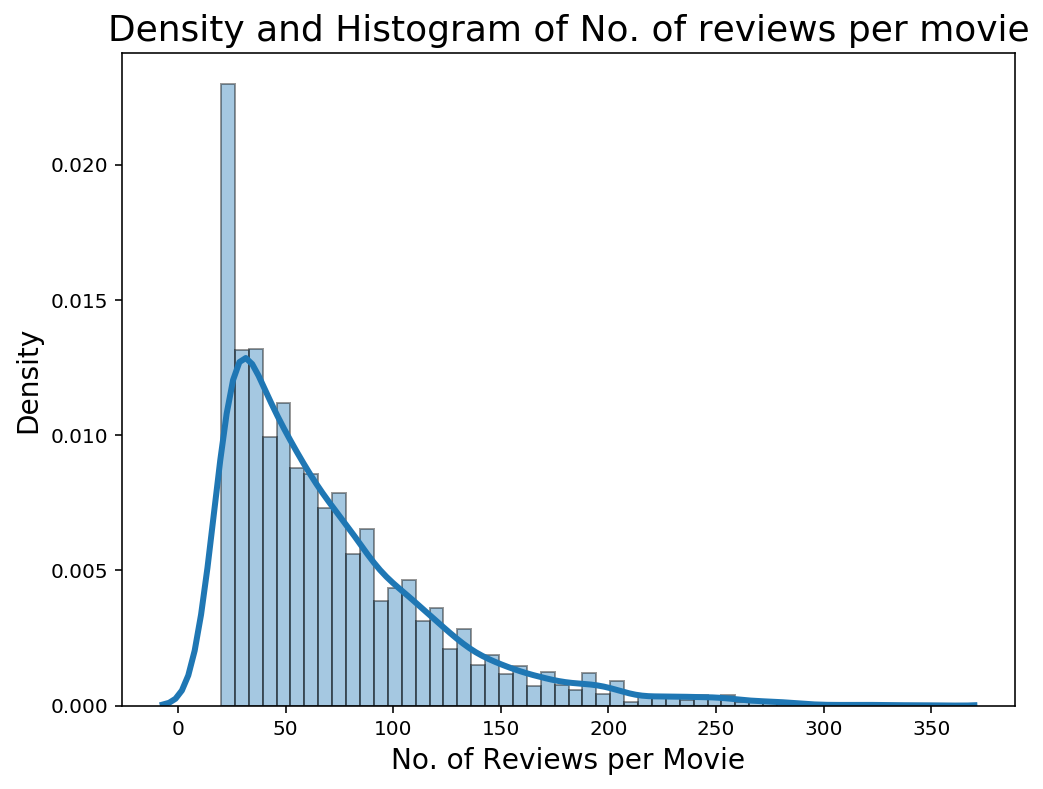

In [118]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("Density and Histogram of No. of reviews per movie", fontsize=18)

ax = sns.distplot(num_reviews["counts"], hist=True, kde=True, bins=50,
                  color ="tab:blue", hist_kws={"edgecolor":"black"}, kde_kws={"linewidth": 3})
ax.set_xlabel("No. of Reviews per Movie", size=14)
ax.set_ylabel("Density", size=14)

plt.show()

### 7.2) EDA #2: Finding the range of years that the movie reviews are published
- As these movie reviews were scraped from RottenTomatoes, a large majority of the movie reviews were published after the year 2000 (the year RottenTomatoes.com was founded).
- Since then, the number of reviews per year has increased greatly year-by-year.

In [119]:
# Converting the "review_pub_date" feature into a datetime object

review_pub_years = pd.to_datetime(df_final["review_pub_date"], infer_datetime_format=True).dt.year

In [120]:
# Converting into a pd.DataFrame format for easier viewing

review_pub_years = pd.DataFrame(review_pub_years.value_counts()).reset_index()
review_pub_years.columns = ["review_pub_year", "count"]
review_pub_years.head()

,review_pub_year,count
0,2019,31725
1,2018,29047
2,2017,21966
3,2016,21412
4,2015,16305


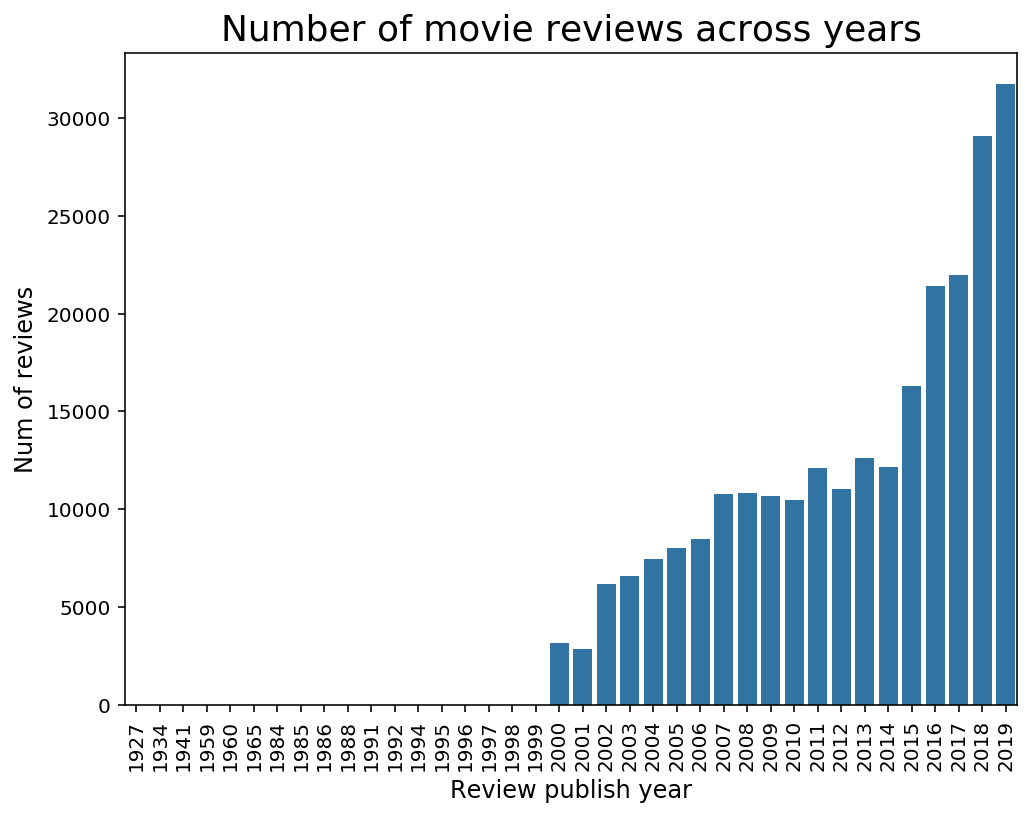

In [121]:
# Plotting in a graph

plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
plt.title("Number of movie reviews across years", fontsize=18)

ax = sns.barplot(x="review_pub_year", y="count", data=review_pub_years, orient="v", color="tab:blue")
ax.set_xlabel("Review publish year", size=12)
ax.set_ylabel("Num of reviews", size=12)

plt.show()

### 7.3) EDA #3: Finding the years in which the movies were released
- As RottenTomatoes only began seriously collecting movie reviews after 2000, it would be interesting to find out the range of years in which the movies were actually released.
- From our analysis, it was found that there are 179 movies in our dataset that were released prior to the year 2000.
- Between the period of 2000-2010, there are around 125 movies released every year.
- This number has since increased to 225 movies a year for the period 2015 to present.

In [122]:
# There are 179 movies in our dataset that were released prior to the year 2000

ls_pre2000_movie_titles = df_final["title_year"][df_final["year_released"] < 2000].unique()
len(ls_pre2000_movie_titles)

179

In [123]:
# Counting the number of movies released per particular year

movie_release_year = df_final.groupby("year_released")["title_year"].nunique()

In [124]:
# Converting the into a pd.DataFrame format for easier viewing

movie_release_year = pd.DataFrame(movie_release_year).reset_index()
movie_release_year.columns = ["movie_release_year", "count"]

In [125]:
movie_release_year.head()

,movie_release_year,count
0,1927,2
1,1931,1
2,1934,1
3,1941,1
4,1942,1


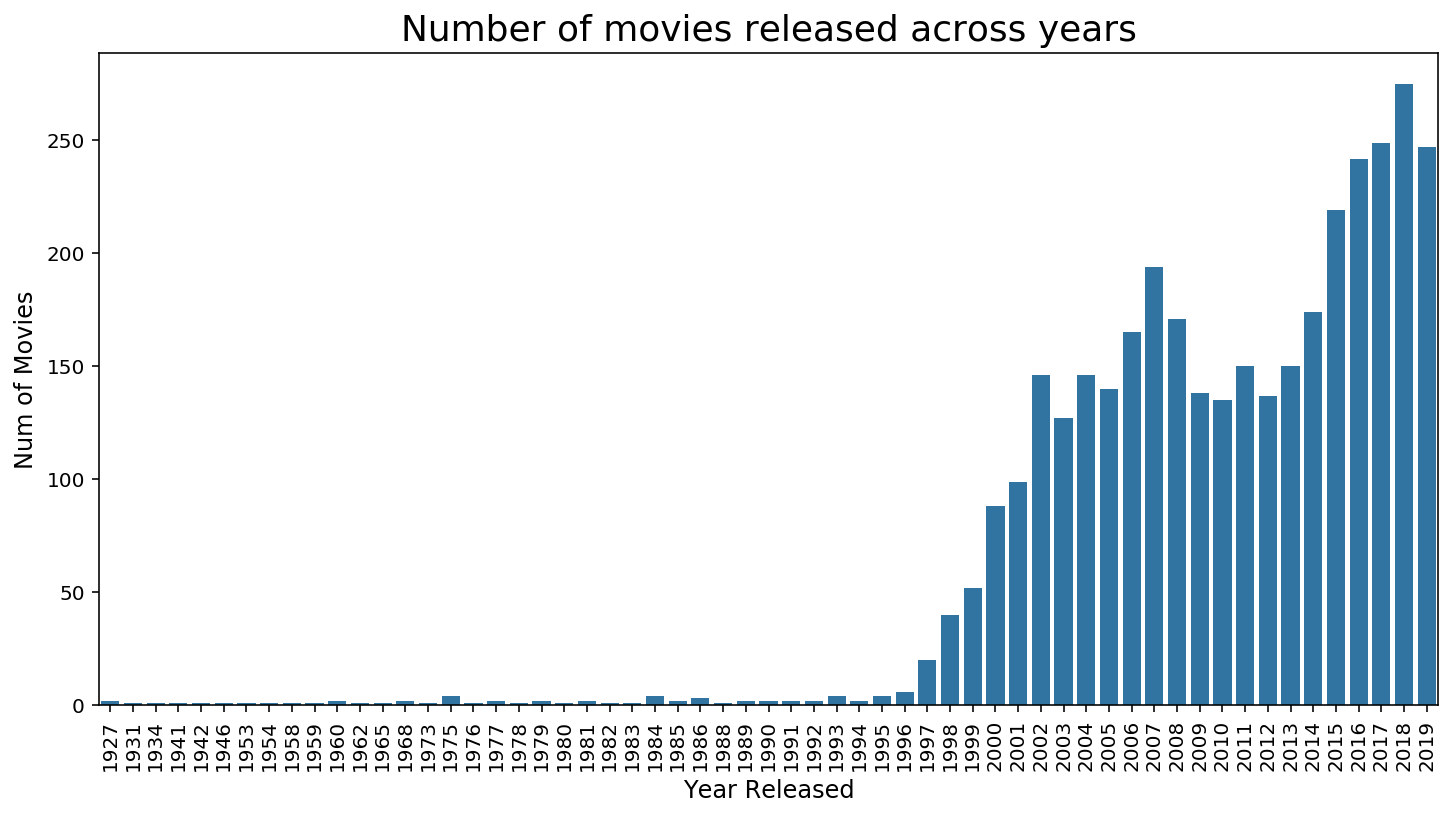

In [126]:
# Plotting in a graph

plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
plt.title("Number of movies released across years", fontsize=18)

ax = sns.barplot(x="movie_release_year", y="count", data=movie_release_year, orient="v", color="tab:blue")
ax.set_xlabel("Year Released", size=12)
ax.set_ylabel("Num of Movies", size=12)

plt.show()

### 7.4) EDA #4: Finding the top 20 most reviewed movies in our dataset
- The top 20 most reviewed movies all had greater than 260 reviews.
- As they were all released in the past 3 years, there could be a possible review number bias towards recent movies.
- **Fun fact**: I have watched 15 out of the 20 of them.

In [127]:
# Retreiving the top 20 most rated movies

top20_most_reviewed = num_reviews.head(20)

In [128]:
top20_most_reviewed

,title_year,counts
0,Joker (2019),343
1,Us (2019),322
2,A Star Is Born (2018),318
3,Solo: A Star Wars Story (2018),304
4,Star Wars: The Last Jedi (2017),291
5,Dunkirk (2017),284
6,First Man (2018),284
7,Jurassic World: Fallen Kingdom (2018),282
8,Toy Story 4 (2019),282
9,Mission: Impossible - Fallout (2018),278


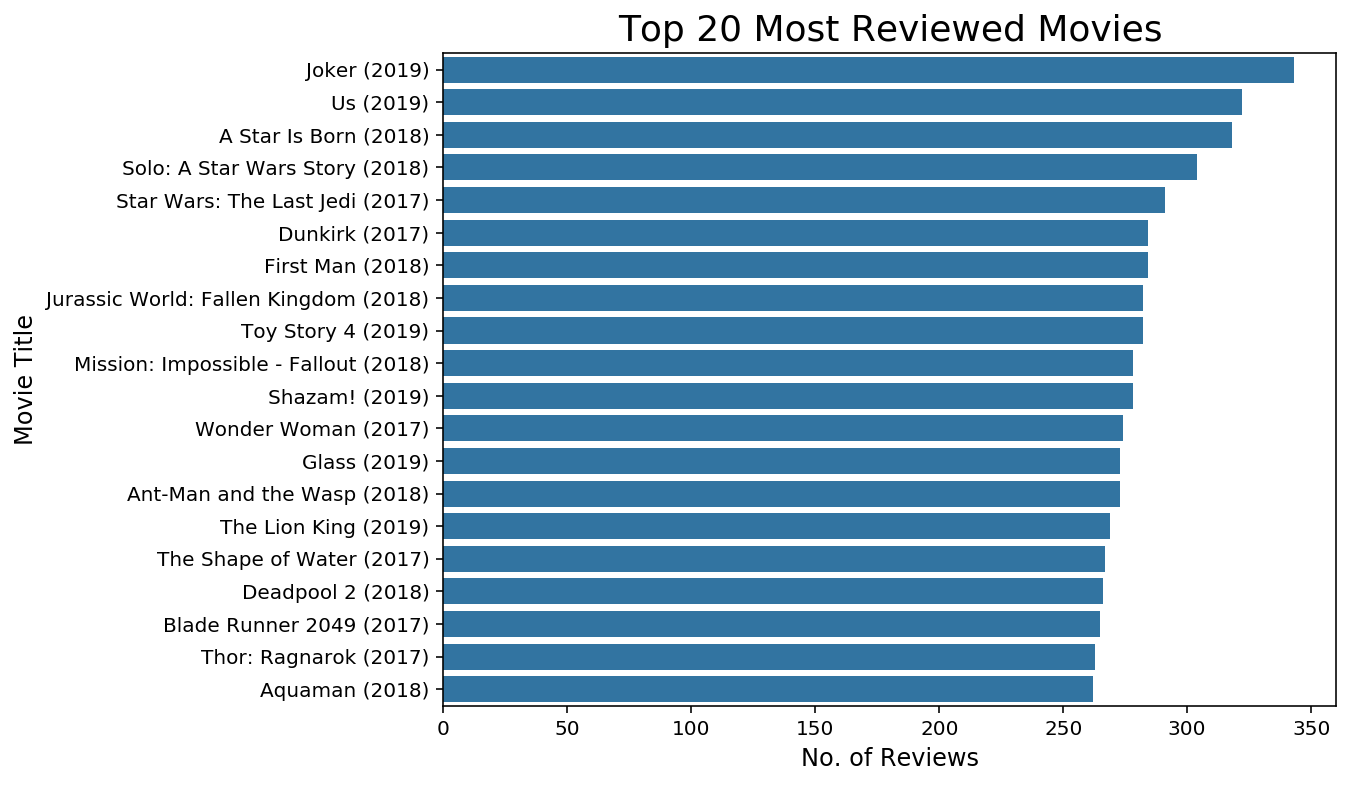

In [129]:
# Plotting in a graph

plt.figure(figsize=(8, 6))
plt.title("Top 20 Most Reviewed Movies", fontsize=18)

ax = sns.barplot(x="counts", y="title_year", data=top20_most_reviewed, orient="h", color="tab:blue")
ax.set_xlabel("No. of Reviews", size=12)
ax.set_ylabel("Movie Title", size=12)

plt.show()

### 7.5) EDA #5: Finding the Top 10 most reviewed movie genre
- The most reviewed movie genre is Drama, followed by Comedy, Documentary, Romance, Thriller and Crime.
- Notably, Action and Science-fiction is not on this Top 10 list.

In [130]:
# Getting the number of reviews per genre category

genre_counts = df_final.groupby("genres")["title_year"].size().sort_values(ascending=False)

In [131]:
# Displaying in a pd.DataFrame format

top10_genre_counts = pd.DataFrame(genre_counts).reset_index()
top10_genre_counts.columns = ["genres", "counts"]
top10_genre_counts.head(10)

,genres,counts
0,Drama,32882
1,Comedy,18605
2,Comedy|Drama,11969
3,Documentary,9919
4,Drama|Romance,8182
5,Comedy|Romance,6878
6,Comedy|Drama|Romance,6815
7,Drama|Thriller,6263
8,Crime|Drama|Thriller,4747
9,Crime|Drama,4515


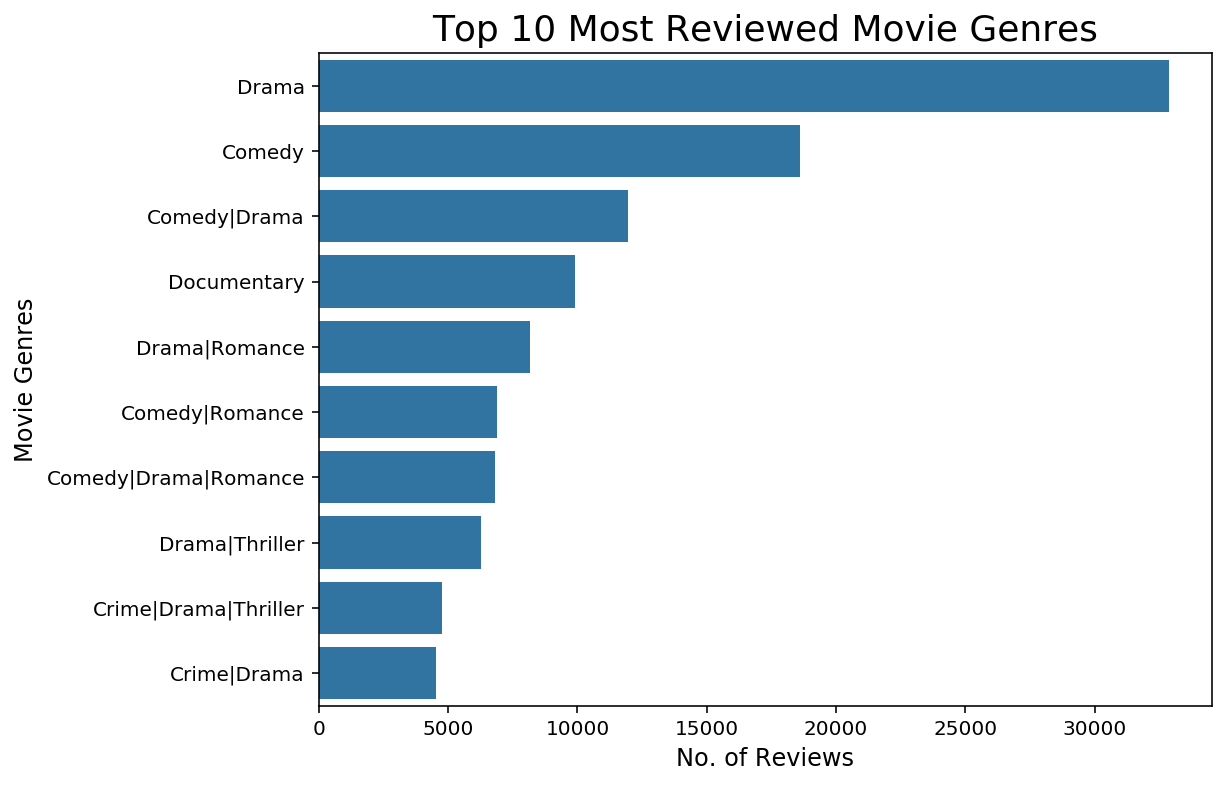

In [132]:
# Plotting in a graph

plt.figure(figsize=(8, 6))
plt.title("Top 10 Most Reviewed Movie Genres", fontsize=18)

ax = sns.barplot(x="counts", y="genres", data=top10_genre_counts.head(10), orient="h", color="tab:blue")
ax.set_xlabel("No. of Reviews", size=12)
ax.set_ylabel("Movie Genres", size=12)

plt.show()

### 7.6) EDA #6: Finding the number of reviews per movie score band
- Since movie ratings are rated on a continuous scale of 0 to 5, we will now examine the distribution of movie scores in this movie review dataset.
- The majority of movie review scores fall between the ranges of 3-4.5 (>50% of all reviews).
- Interestingly, rarely will a movie do badly (i.e. receive a score of less than 1).

In [133]:
movie_scores = df_final[["title_year", "norm_critic_score"]]

In [134]:
# Defining and binning the review scores

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
group_names = ["0.0 - 0.5", "0.5 - 1.0", "1.0 - 1.5", "1.5 - 2.0",
               "2.0 - 2.5", "2.5 - 3.0", "3.0 - 3.5", "3.5 - 4.0",
               "4.0 - 4.5", "4.5 - 5.0"]

movie_scores["score_bin"] = pd.cut(df_final["norm_critic_score"], 
                                   bins,
                                   right=False,
                                   labels=group_names)

In [135]:
# Getting the counts for each bin

score_bins = pd.DataFrame(movie_scores.groupby("score_bin").size(), columns=["counts"])
score_bins = score_bins.reset_index()   # Moving the score_bin as a column
score_bins

,score_bin,counts
0,0.0 - 0.5,1777
1,0.5 - 1.0,1620
2,1.0 - 1.5,13318
3,1.5 - 2.0,11612
4,2.0 - 2.5,28221
5,2.5 - 3.0,29159
6,3.0 - 3.5,50000
7,3.5 - 4.0,37038
8,4.0 - 4.5,55913
9,4.5 - 5.0,10478


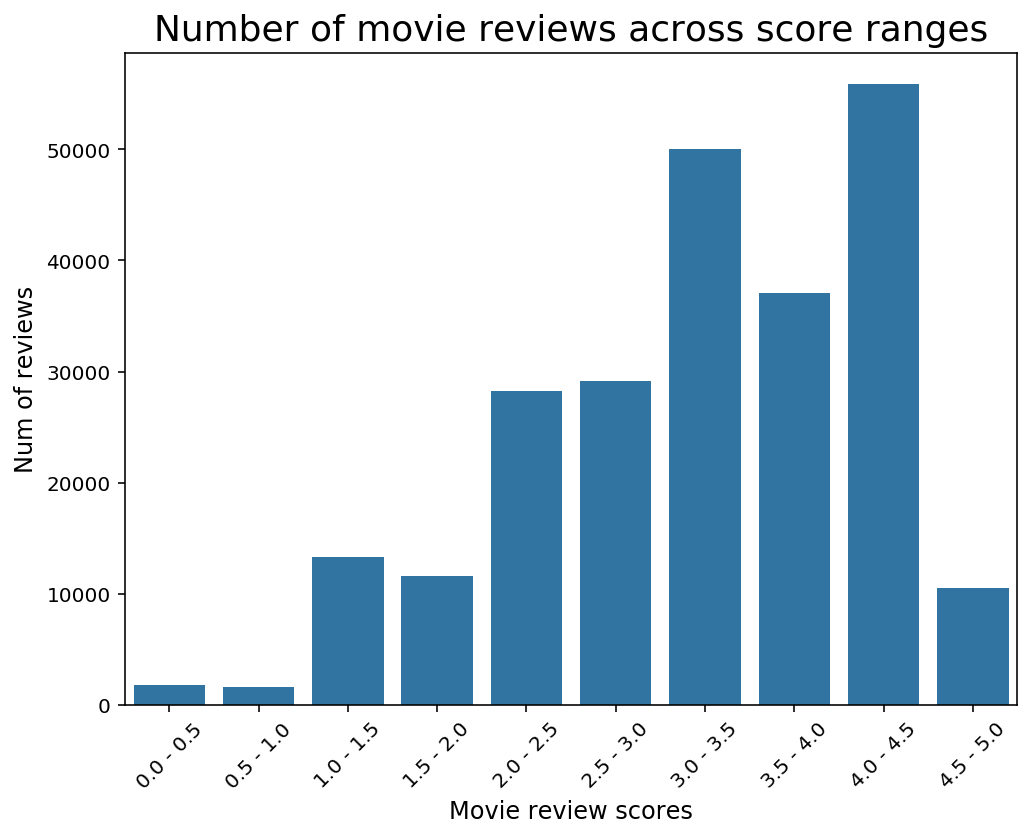

In [136]:
# Plotting the review scores onto a graph for easier visualization

plt.figure(figsize=(8, 6))
plt.xticks(rotation=45)
plt.title("Number of movie reviews across score ranges", fontsize=18)

ax = sns.barplot(x="score_bin", y="counts", data=score_bins, orient="v", color="tab:blue")
ax.set_xlabel("Movie review scores", size=12)
ax.set_ylabel("Num of reviews", size=12)

plt.show()

### 7.7) EDA #7: Finding the top 20 highest rated movies (of all time)
- We will be calculating the average movie score and proceeding to rank them. The top 20 highest rated movie of all time will then be presented.
- Interestingly, none of the movies were from the past 2 decades (2000-2019). 
- It may be possible that rating-based recommendations may not cater to the current generation of movie watchers.

In [137]:
# Calculating and ranking the mean movie scores from highest to lowest

mean_movie_score = df_final[["title_year", "norm_critic_score"]].groupby("title_year").mean().reset_index()
mean_movie_score = mean_movie_score.sort_values("norm_critic_score", ascending=False)

In [138]:
# Showing the Top 20 highest rated movies

mean_movie_score.head(20)

,title_year,norm_critic_score
649,Citizen Kane (1941),4.911290
25,2001: A Space Odyssey (1968),4.897059
2772,Star Wars: Episode V - The Empire Strikes Back...,4.880952
2364,Psycho (1960),4.880870
2894,Taxi Driver (1976),4.860667
2406,Ran (1985),4.860455
2367,Pulp Fiction (1994),4.827838
1570,Jaws (1975),4.825714
1926,Metropolis (1927),4.816667
3240,Tokyo Story (Tôkyô monogatari) (1953),4.811905


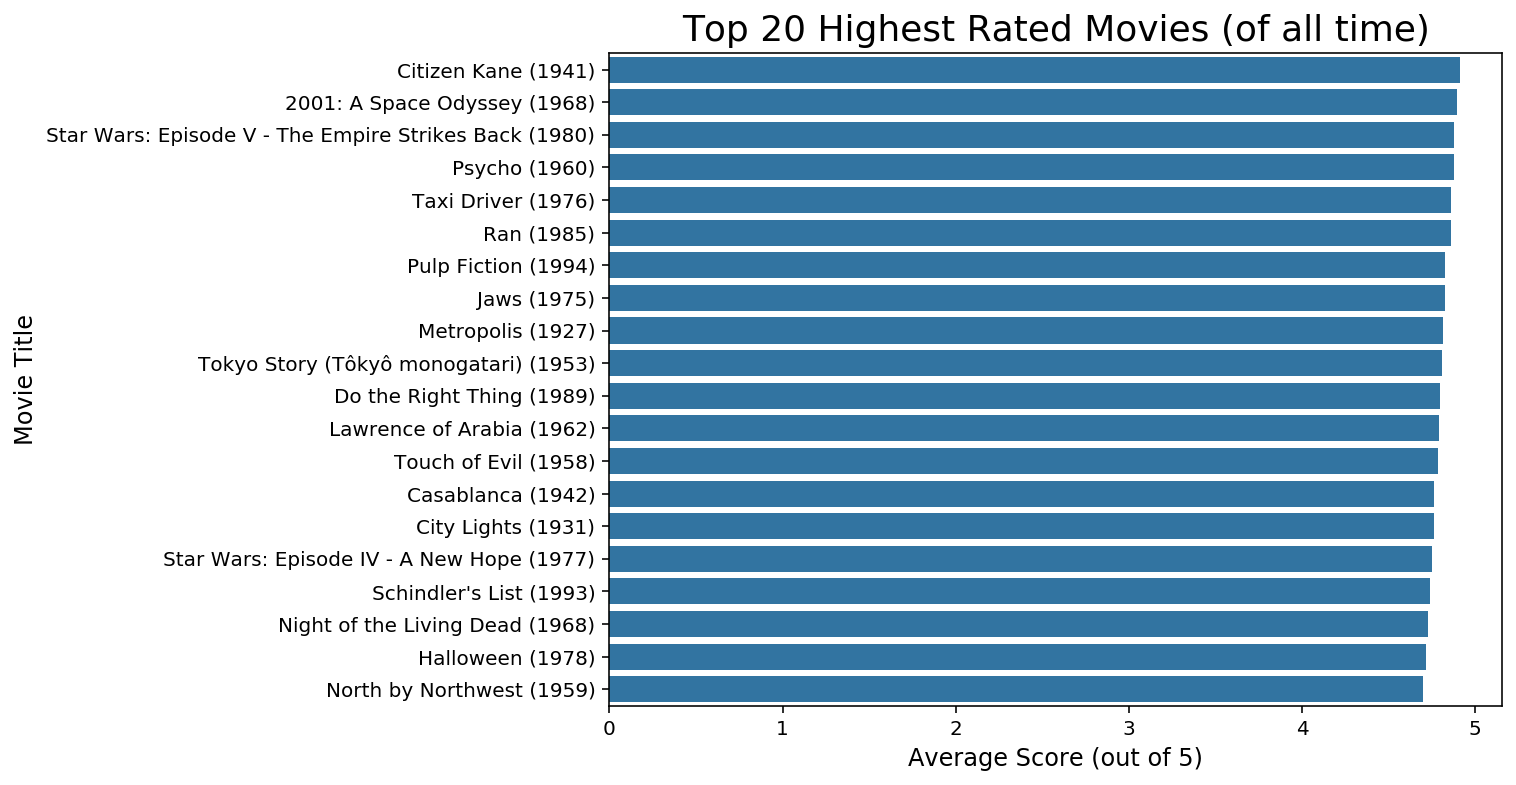

In [139]:
# Converting into a graphical format

top20_highest_rated = pd.DataFrame(mean_movie_score, columns=["title_year", "norm_critic_score"]).head(20)


# Plotting in a graph

plt.figure(figsize=(8, 6))
plt.title("Top 20 Highest Rated Movies (of all time)", fontsize=18)

ax = sns.barplot(x="norm_critic_score", y="title_year", data=top20_highest_rated, orient="h", color="tab:blue")
ax.set_xlabel("Average Score (out of 5)", size=12)
ax.set_ylabel("Movie Title", size=12)

plt.show()

### 7.8) EDA #8: Finding the top 20 highest rated movies (in the past 5 years)
- To see which are the highest rated movies for this current generation, we will be limiting our dataset to the past 5 years.
- Approximately half of these movies are obscure to me.

In [140]:
# Filtering out movies older than 5 years old

df_final_5y = df_final[["title_year", "norm_critic_score"]][df_final["year_released"] >= 2015]
mean_movie_score_5y = df_final_5y.groupby("title_year").mean()


# Ranking the movies released in the past 5 years 

mean_movie_score_5y = mean_movie_score_5y.sort_values("norm_critic_score", ascending=False).reset_index()
mean_movie_score_5y.head(20)

,title_year,norm_critic_score
0,O.J.: Made in America (2016),4.700000
1,For Sama (2019),4.542979
2,Apollo 11 (2019),4.513391
3,Marriage Story (2019),4.512386
4,Roma (2018),4.502773
5,The Tale (2018),4.495862
6,Son of Saul (2015),4.471453
7,Inside Out (2015),4.471194
8,I Am Not Your Negro (2017),4.449417
9,The Irishman (2019),4.435208


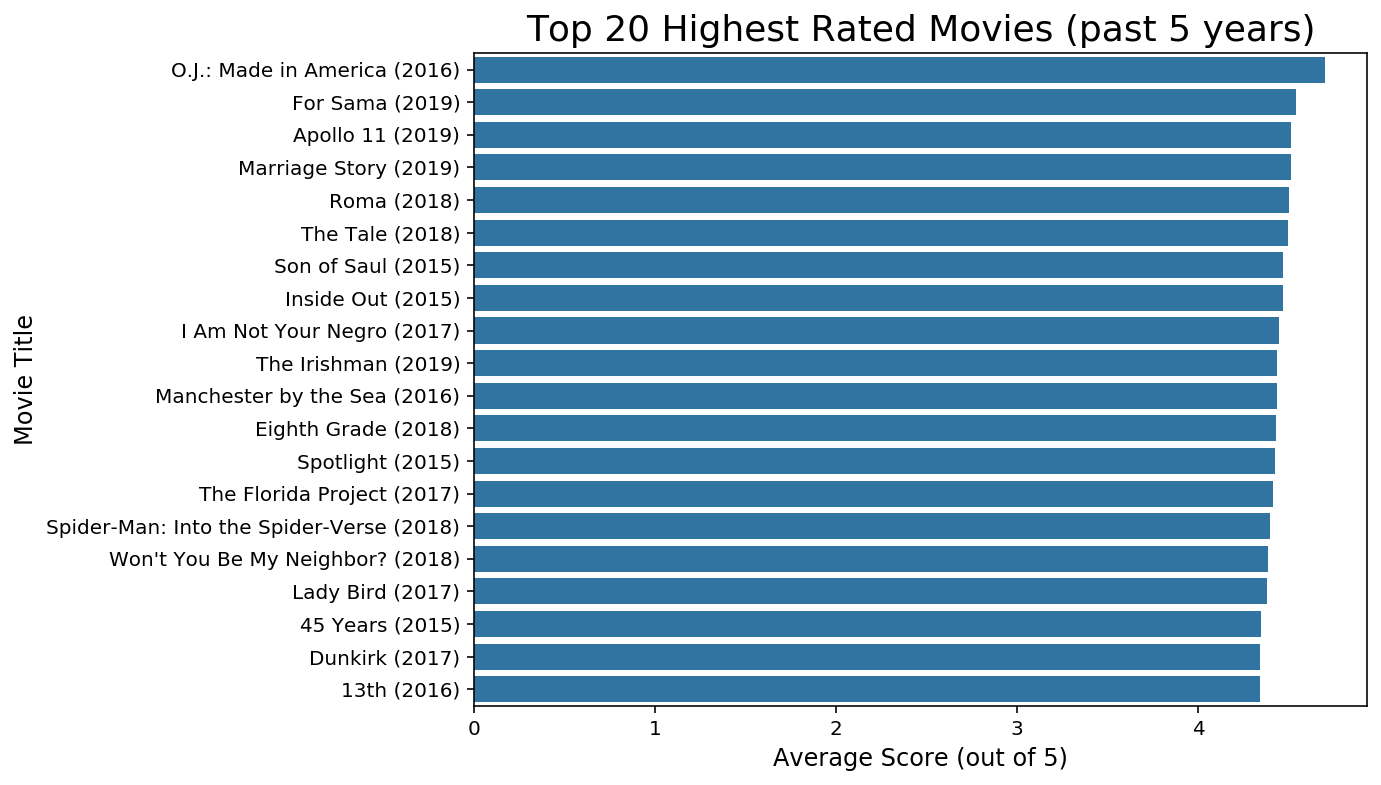

In [141]:
# Converting into a graphical format

top20_5y_movie_score = pd.DataFrame(mean_movie_score_5y, columns=["title_year", "norm_critic_score"]).head(20)


# Plotting in a graph

plt.figure(figsize=(8, 6))
plt.title("Top 20 Highest Rated Movies (past 5 years)", fontsize=18)

ax = sns.barplot(x="norm_critic_score", y="title_year", data=top20_5y_movie_score, orient="h", color="tab:blue")
ax.set_xlabel("Average Score (out of 5)", size=12)
ax.set_ylabel("Movie Title", size=12)

plt.show()

### 7.9) EDA #9: Finding the top 10 highest rated movie directors (of all time)
- All of these directors have already passed away. 
- The generational problem may indeed be a problem for our recommendation system.

In [142]:
# Calculating and ranking the mean movie scores from highest to lowest, max score = 5

mean_director_score = df_final.groupby("director")["norm_critic_score"].mean().sort_values(ascending=False)
mean_director_score = pd.DataFrame(mean_director_score).reset_index()

In [143]:
mean_director_score.columns = ["director", "director_score"]   # Renaming the features
mean_director_score.head(10)

,director,director_score
0,Irvin Kershner,4.880952
1,Akira Kurosawa,4.860455
2,Orson Welles,4.857273
3,Fritz Lang,4.816667
4,Yasujirô Ozu,4.811905
5,David Lean,4.791481
6,Alfred Hitchcock,4.791087
7,Michael Curtiz,4.765200
8,Charles Chaplin,4.765000
9,John Lasseter,4.684167


### 7.10) EDA #10: Finding the Top 10 most reviewed movie directors (of all time)
- Within our movie review dataset, we would like to know which movie directors appear the most frequently.
- Of the top 3 most reviewed movie directors, 2 of them are also movie actors:
    - Woody Allen
    - Clint Eastwood

In [144]:
# Calculating the movie director with the most number of movie reviews

prolific_directors = df_final.groupby("director")["title_year"].size().sort_values(ascending=False)
prolific_directors = pd.DataFrame(prolific_directors).reset_index()
prolific_directors.columns = ["director", "counts"]
prolific_directors.head(10)

,director,counts
0,Ridley Scott,1813
1,Woody Allen,1689
2,Clint Eastwood,1534
3,Steven Soderbergh,1492
4,Rob Marshall,1467
5,Tim Burton,1439
6,Steven Spielberg,1388
7,Ron Howard,1239
8,Bryan Singer,1216
9,Zack Snyder,1173


### 7.11) EDA #11: Finding the Top 10 highest rated movie cast trio
The movie cast trio which appear in this list are correlated with movies with high scores (see section 4.8).
- Orson Welles, Joseph Cotten, Dorothy Comingore:
    - Citizen Kane (1941) (Rank #1)
- Keir Dullea, Gary Lockwood, William Sylvester: 
    - 2001: A Space Odyssey (1968) (Rank #2)
- Anthony Perkins, Janet Leigh, Vera Miles: 
    - Psycho (1960) (Rank #4)

In [145]:
# Calculating and ranking the mean movie scores from highest to lowest, max score = 5

mean_cast_trio_score = df_final.groupby("cast")["norm_critic_score"].mean().sort_values(ascending=False)
mean_cast_trio_score = pd.DataFrame(mean_cast_trio_score).reset_index()

In [146]:
mean_cast_trio_score.columns = ["cast_trio", "cast_trio_score"]   # Renaming the features
mean_cast_trio_score.head(10)

,cast_trio,cast_trio_score
0,"Orson Welles, Joseph Cotten, Dorothy Comingore",4.911290
1,"Keir Dullea, Gary Lockwood, William Sylvester",4.897059
2,"Anthony Perkins, Janet Leigh, Vera Miles",4.880870
3,"Robert De Niro, Jodie Foster, Cybill Shepherd",4.860667
4,"Tatsuya Nakadai, Akira Terao, Jinpachi Nezu",4.860455
5,"John Travolta, Uma Thurman, Samuel L. Jackson",4.827838
6,"Roy Scheider, Robert Shaw, Richard Dreyfuss",4.825714
7,"Brigitte Helm, Alfred Abel, Gustav Fröhlich",4.816667
8,"Chishû Ryû, Chieko Higashiyama, Sô Yamamura",4.811905
9,"Mark Hamill, Harrison Ford, Carrie Fisher",4.811111


### 7.12) EDA #12: Finding the Top 10 most reviewed movie cast
- Out dataset comprises of the first three billed actors/actresses in the movie.
- The top 3 most reviewed movie cast in our dataset are from the "Hunger Games", "X-men" and "Harry Potter" series franchise.
 - Jennifer Lawrence, Josh Hutcherson, Liam Hemsworth (Hunger Games)
 - James McAvoy, Michael Fassbender, Jennifer Lawrence (X-men)
 - Daniel Radcliffe, Emma Watson, Rupert Grint (Harry Potter)
- The next 7 movie cast-trio are a mixture of single or franchise movies.

In [147]:
# The most frequently reviewed movie cast trio is the from the "Hunger Games", "X-men", and "Harry Potter" series.

cast_trio = df_final.groupby("cast")["title_year"].size().sort_values(ascending=False)
cast_trio = pd.DataFrame(cast_trio).reset_index()
cast_trio.columns = ["cast", "counts"]
cast_trio.head(10)

,cast,counts
0,"Jennifer Lawrence, Josh Hutcherson, Liam Hemsw...",663
1,"James McAvoy, Michael Fassbender, Jennifer Law...",607
2,"Daniel Radcliffe, Emma Watson, Rupert Grint",431
3,"Michael B. Jordan, Sylvester Stallone, Tessa T...",376
4,"Joaquin Phoenix, Robert De Niro, Zazie Beetz",343
5,"Lupita Nyong'o, Winston Duke, Elisabeth Moss",322
6,"Lady Gaga, Bradley Cooper, Sam Elliott",318
7,"Mia Wasikowska, Johnny Depp, Helena Bonham Carter",307
8,"Alden Ehrenreich, Woody Harrelson, Emilia Clarke",304
9,"Daisy Ridley, John Boyega, Mark Hamill",291


### 7.13) EDA #13: Finding the Top 10 most and least prolific movie critics
- The Top 10 most prolific movie critics have reviewed around 2000 movies in their entire career.
- On the other hand, least prolific critics have only reviewed 1 movie in their review career.

In [148]:
prolific_critic = df_final.groupby("critic_name")["title_year"].size().sort_values(ascending=False)
prolific_critic = pd.DataFrame(prolific_critic).reset_index()
prolific_critic.columns = ["critic_name", "counts"]

# The top 10 most prolific critic
prolific_critic.head(10)

,critic_name,counts
0,Frank Swietek,2683
1,Roger Moore,2463
2,Nell Minow,2325
3,James Berardinelli,2143
4,Eric D. Snider,2086
5,Rich Cline,2000
6,Susan Granger,1991
7,David Nusair,1944
8,Laura Clifford,1925
9,Jeffrey M. Anderson,1844


In [149]:
# The 10 least prolific critic, these critics only have 1 review in their name

prolific_critic.tail(10)

,critic_name,counts
2085,Bridget Jones,1
2086,Denise Pieniazek,1
2087,Marianna Lozowska,1
2088,Margaret Lyons,1
2089,Janaya Greene,1
2090,Jane Mulkerrins,1
2091,Madeline Joint,1
2092,M Suganth,1
2093,Deborah Ross,1
2094,Carol Midgley,1


### 7.14) EDA #14: Finding the distribution of movie reviews across movie critics.
- Building upon section 4.14, we will now determine the distribution of number of reviews made per movie critic.
- There are total of 2095 unique movie critics in our list, of which the mean number of reviews per critic is 121.
- The median number of movie reviews per critic is 20, suggesting a strong positive skew.

In [150]:
# Getting the statistics for number of reviews per movie

pd.DataFrame(prolific_critic.describe(), columns=["counts"])

,counts
count,2095.000000
mean,121.291169
std,270.465680
min,1.000000
25%,3.000000
50%,20.000000
75%,105.000000
max,2683.000000


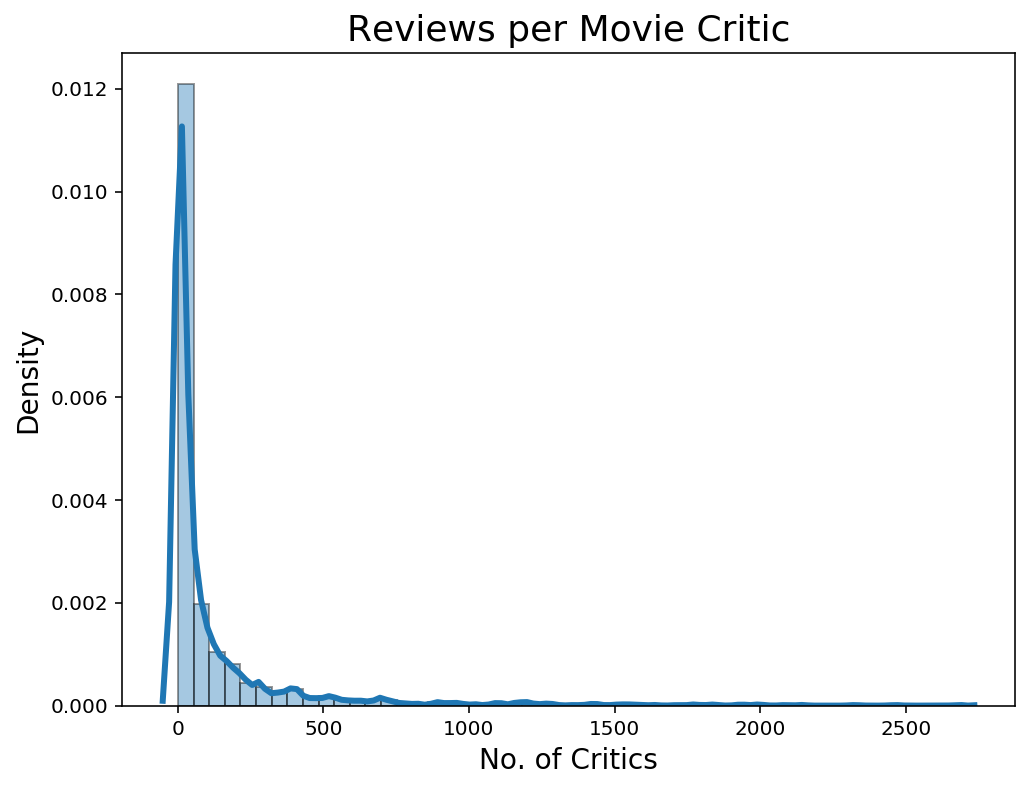

In [151]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("Reviews per Movie Critic", fontsize=18)

ax = sns.distplot(prolific_critic["counts"], hist=True, kde=True, bins=50,
                  color ="tab:blue", hist_kws={"edgecolor":"black"}, kde_kws={"linewidth": 3})
ax.set_xlabel("No. of Critics", size=14)
ax.set_ylabel("Density", size=14)

plt.show()

## 8) Data Modelling
In this section, we will be testing various prediction algorithms (on our training data) to determine their accuracy in returning actual movies watch (on our test data). To build and analyse our recommender system, we will be using the Surprise package (http://surpriselib.com/), which was designed to handle explicit rating data.

### 8.1) Defining our movie review dataset
- For any collaborative movie filtering approach, we only need 3 features:
    - User ID ("critic_name")
    - Movie title ("title_year")
    - User score ("norm_critic_score")
- Therefore, we will be defining our modelling dataset containing only these three features.

In [152]:
df_user_reviews = df_final[["critic_name", "title_year", "norm_critic_score"]]

In [153]:
df_user_reviews.head()

,critic_name,title_year,norm_critic_score
0,Josefine A.,Vita & Virginia (2019),2.0
1,Nigel Andrews,Vita & Virginia (2019),2.0
2,Tim Appelo,Vita & Virginia (2019),3.0
3,Lynden Barber,Vita & Virginia (2019),3.5
4,Matthew Bond,Vita & Virginia (2019),3.0


### 8.2) Converting "critic_name" and "title_year" into integers
- For the ease of EDA and modelling purposes, we will be converting "critic_name" and "title_year" into an ID format.

In [154]:
# Creating a list of unique critic names

ls_critic_names = list(df_user_reviews["critic_name"].unique())
ls_critic_names[:5]

['Josefine A.', 'Nigel Andrews', 'Tim Appelo', 'Lynden Barber', 'Matthew Bond']

In [155]:
# Creating a list of unique movie titles

ls_movie_titles = list(df_user_reviews["title_year"].unique())
ls_movie_titles[:5]

['Vita & Virginia (2019)',
 'Destination Wedding (2018)',
 'Bombshell: The Hedy Lamarr Story (2017)',
 'Photograph (2019)',
 'Toy Story 4 (2019)']

In [156]:
# Creating a name and movie ID conversion dict

d_critic_id = {}
d_movie_id = {}

for i in range(len(ls_critic_names)):
    d_critic_id[ls_critic_names[i]] = i+1

for j in range(len(ls_movie_titles)):
    d_movie_id[ls_movie_titles[j]] = j+1

In [157]:
# The critic ID dictionary has been successfully made

d_critic_id.get(1)

In [158]:
# The movie ID dictionary has been successfully made

d_movie_id.get(1)

In [159]:
# Converting the "critic_id" and "title_id" features into their respective IDs

df_user_reviews["critic_id"] = df_user_reviews["critic_name"].apply(lambda x: d_critic_id[str(x)])
df_user_reviews["title_id"] = df_user_reviews["title_year"].apply(lambda x: d_movie_id[str(x)])

In [160]:
# Dropping the "critic_name" and "title_year" features

df_user_reviews = df_user_reviews.drop(["critic_name", "title_year"], axis=1)


# Rearranging the features for presentability

df_user_reviews = df_user_reviews[["critic_id", "title_id", "norm_critic_score"]]

In [161]:
# The dataframe has been successfully converted

df_user_reviews.head()

,critic_id,title_id,norm_critic_score
0,1,1,2.0
1,2,1,2.0
2,3,1,3.0
3,4,1,3.5
4,5,1,3.0


In [162]:
# There are no missing values

df_user_reviews.isnull().sum()

critic_id            0
title_id             0
norm_critic_score    0
dtype: int64

In [163]:
# The shape of the modelling dataset remains the same with 254105 reviews

df_user_reviews.shape

(254105, 3)

In [164]:
# All datatypes have been converted to either int64 or float64, hence meaning that all rows have been converted

df_user_reviews.dtypes

critic_id              int64
title_id               int64
norm_critic_score    float64
dtype: object

### 8.3) Train-Test split of our data

In [165]:
# Importing in the packages from the Surprise library

import random
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate

In [166]:
# Instantiating the classes

reader = Reader(line_format="user item rating", rating_scale=(0, 5))   # User/Item/Rating
data = Dataset.load_from_df(df_user_reviews, reader)                   # Reading in df_user_reviews
raw_ratings = data.raw_ratings

In [167]:
# Shuffling the ratings, seed number = 42

random.Random(42).shuffle(raw_ratings)

In [168]:
raw_ratings[:5]

[(27, 1113, 2.5, None),
 (9, 1452, 4.0, None),
 (112, 1365, 4.0, None),
 (359, 554, 4.0, None),
 (10, 2470, 4.0, None)]

In [169]:
# Train/test split at 70/30 ratio

threshold = int(0.7 * len(raw_ratings))
train_set = raw_ratings[:threshold]
test_set = raw_ratings[threshold:]

In [170]:
# Number of reviews in the training or test sets
print(f"There are {len(train_set)} reviews in the training set.")
print(f"There are {len(test_set)} reviews in the test set.")

There are 177873 reviews in the training set.
There are 76232 reviews in the test set.


### 8.4) Defining functions to simplfy the testing of our models
- These functions will apply cross validation, fitting of the training data, and evaluation of the test data.
- The metrics used to access our models are: (adapted from Surprise library FAQ)
    - **RMSE**
    - **Precision @ k**: Among all the recommended movies, what is the percentage of recommended movies that are above the threshold.
        - Formula: (Recommended movies that are relevant) / (Recommended items)
    - **Recall @ k**: Among all the movies above the treshold, how many of these are recommended? 
        - Formula: (Recommended movies that are relevant) / (Relevant items)
- Note from documentation (https://surprise.readthedocs.io/en/stable/FAQ.html): 
    - An item is considered relevant if its true rating is greater than a given threshold. 
    - An item is considered recommended if its estimated rating is greater than the threshold, and if it is among the k highest estimated ratings.

In [171]:
# Function to return CV-results and RMSE values

def train_predict(model_name, training_data, testing_data):

    # Function to perform cross validation (using the entire dataset)
    cross_val = cross_validate(algo=model_name, 
                               data=data, 
                               measures=["RMSE"],
                               cv=5,
                               n_jobs=-1)
    cv5_array = cross_val["test_rmse"]
    cv5_mean = round(cross_val["test_rmse"].mean(), 3)
    
    # Defining the training and test dataset
    data.raw_ratings = training_data  # The "data" is now set to the training set
    trainset = data.build_full_trainset()
    
    # Fitting our model on the training dataset
    model_name.fit(trainset)

    # Compute biased accuracy on training dataset
    train_predictions = model_name.test(trainset.build_testset())
    train_accuracy = round(accuracy.rmse(train_predictions, verbose=False), 3)
    
    # Defining test_predictions as a global variable for later functions
    global test_predictions   
    
    # Calculating the Model's accuracy on the test dataset
    testset = data.construct_testset(testing_data)   # The "data" is now set to the test set
    test_predictions = model_name.test(testset)
    test_accuracy = round(accuracy.rmse(test_predictions, verbose=False), 3)

    # Output the calculated values
    print("=======================================================")
    print(f"The 5-fold cross validation RMSE scores are:\n{cv5_array}")
    print(f"The mean cross validation RMSE score is: {cv5_mean}")
    print("=======================================================")
    print(f"The model's RMSE on training data is: {train_accuracy}")
    print(f"The model's RMSE on test data is: {test_accuracy}")
    print("=======================================================")

In [172]:
# Function to calculate the precision/recall (Adapted from Surprise library FAQ)

def precision_recall_at_k(prediction_dataset, k_num, threshold_num):
    
    # Mapping the predictions to each user.
    true_user_estimates = defaultdict(list)
    
    # A prediction dataset has 5 values
    # uid=raw_user_id, iid=raw_item_id, r_ui=true_rating, est=estimated_rating, details=additional_useful_info
    for uid, iid, r_ui, est, details in prediction_dataset:
        
        true_user_estimates[uid].append((est, r_ui))   # Appends estimated and true rating for each user
    
    # Creaing a dictionary to store the precision and recall values
    precisions = {}
    recalls = {}
    
    for uid, user_ratings in true_user_estimates.items():

        # Sort user's estimated ratings from highest to lowest
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant movies (i.e., true rating greater than threshold)
        num_relevant = sum((r_ui >= threshold_num) for (_, r_ui) in user_ratings)

        # Number of recommended movies in top k
        num_rec_k = sum((est >= threshold_num) for (est, _) in user_ratings[:k_num])

        # Number of relevant and recommended items in top k
        num_relevant_rec_k = sum(((r_ui >= threshold_num) and (est >= threshold_num)) 
                                 for (est, true_r) in user_ratings[:k_num])

        # Precision@K (i.e. Percentage of recommended movies which are relevant)
        # Stores values in dictionary
        precisions[uid] = (num_relevant_rec_k / num_rec_k) if num_rec_k != 0 else 0

        # Recall@K (i.e. Percentage of relevant items that are recommended
        # Stores values in dictionary
        recalls[uid] = (num_relevant_rec_k / num_relevant) if num_relevant != 0 else 0

    # Calculating the average precision and recall across all users
    precision_all_users = sum(x for x in precisions.values()) / len(precisions)
    recall_all_users = sum(x for x in recalls.values()) / len(recalls)

    # Output the calculated values
    print(f"The average precision for all users is: {round(precision_all_users, 3)}")
    print(f"The average recall for all users is: {round(recall_all_users, 3)}")
    print("=======================================================")

### 8.5) Model Testing (Baseline algorithms)

To determine the efficacy of our models, we will first be deriving the baseline using basic prediction algorithms.
    
- **Normal predictor**: 
    - Algorithm predicting a random rating based on the assumption of normally distributed training set.
- **Baseline predictor**: 
    - Algorithm predicting the baseline estimate for given user and item. Depending on the specific movie's average rating, and the user's average rating, a bias will be added or subtracted to the mean of all movie ratings within the dataset.

In [173]:
# Importing in the algorithms

from surprise.prediction_algorithms import NormalPredictor, BaselineOnly

#### 8.5.1) NormalPredictor model

In [174]:
norm = NormalPredictor()

print("=======================================================")
print("Using the NORMAL PREDICTOR model:")
train_predict(model_name=norm, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the NORMAL PREDICTOR model:
The 5-fold cross validation RMSE scores are:
[1.48652207 1.48607784 1.48729697 1.49559614 1.48492063]
The mean cross validation RMSE score is: 1.488
The model's RMSE on training data is: 1.483
The model's RMSE on test data is: 1.492
The average precision for all users is: 0.745
The average recall for all users is: 0.502


#### 8.5.2) BaselineOnly model

In [175]:
base = BaselineOnly(verbose=False)

print("=======================================================")
print("Using the BASELINEONLY model:")
train_predict(model_name=base, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the BASELINEONLY model:
The 5-fold cross validation RMSE scores are:
[0.78593916 0.78174149 0.77920247 0.78474899 0.78920923]
The mean cross validation RMSE score is: 0.784
The model's RMSE on training data is: 0.76
The model's RMSE on test data is: 0.792
The average precision for all users is: 0.563
The average recall for all users is: 0.231


#### 8.5.3) Results (Baseline algorithms):
- Using the default baseline models, we have derived the following scores (k=10, threshold>=4.0):

|Model|RMSE(train_set)|RMSE(test_set)|Precision@k(test_set)|Recall@k(test_set)|
|:----------------:|:------------:|:------------:|:------------:|:------------:|
|**Normal**|1.484|1.491|0.741|0.487|
|**BaselineOnly**|0.760|0.792|0.563|0.231|

### 8.6) Model Testing (KNN-inspired algorithms)
With the baseline values established, we will now proceed to test more advanced prediction algorithms included in the Surprise package. This section will cover algorithms inspired by the k-nearest neighbor approach (KNN).

- **KNN basic**:
    - Basic KNN collaborative algorithm

- **KNN with means**:
    - KNN taking into account the mean ratings of each user

- **KNN with Z-score**: 
    - KNN taking into account the Z-score normalization of each user

- **KNN baseline**: 
    - KNN taking into account a baseline rating

In [176]:
# Importing in the algorithms

from surprise.prediction_algorithms import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

#### 8.6.1) KNNBasic model

In [177]:
knn_basic = KNNBasic(verbose=False)

print("=======================================================")
print("Using the KNN_BASIC model:")
train_predict(model_name=knn_basic, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the KNN_BASIC model:
The 5-fold cross validation RMSE scores are:
[0.79909556 0.7969787  0.80021593 0.80614287 0.801585  ]
The mean cross validation RMSE score is: 0.801
The model's RMSE on training data is: 0.682
The model's RMSE on test data is: 0.812
The average precision for all users is: 0.652
The average recall for all users is: 0.326


#### 8.6.2) KNNWithMeans model

In [178]:
knn_means = KNNWithMeans(verbose=False)

print("=======================================================")
print("Using the KNN_WITH_MEANS model:")
train_predict(model_name=knn_means, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the KNN_WITH_MEANS model:
The 5-fold cross validation RMSE scores are:
[0.78717479 0.79231098 0.7927844  0.78863543 0.79293226]
The mean cross validation RMSE score is: 0.791
The model's RMSE on training data is: 0.683
The model's RMSE on test data is: 0.801
The average precision for all users is: 0.635
The average recall for all users is: 0.373


#### 8.6.3) KNNWithZScore model

In [179]:
knn_zscore = KNNWithZScore(verbose=False)

print("=======================================================")
print("Using the KNN_WITH_ZSCORE model:")
train_predict(model_name=knn_zscore, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the KNN_WITH_ZSCORE model:
The 5-fold cross validation RMSE scores are:
[0.78837238 0.78181041 0.7867175  0.79006211 0.78505226]
The mean cross validation RMSE score is: 0.786
The model's RMSE on training data is: 0.675
The model's RMSE on test data is: 0.798
The average precision for all users is: 0.608
The average recall for all users is: 0.341


#### 8.6.4) KNNBaseline model

In [180]:
knn_baseline = KNNBaseline(verbose=False)

print("=======================================================")
print("Using the KNN_BASELINE model:")
train_predict(model_name=knn_baseline, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the KNN_BASELINE model:
The 5-fold cross validation RMSE scores are:
[0.77088399 0.76816025 0.76840425 0.76997758 0.76596457]
The mean cross validation RMSE score is: 0.769
The model's RMSE on training data is: 0.658
The model's RMSE on test data is: 0.78
The average precision for all users is: 0.658
The average recall for all users is: 0.329


#### 8.6.5) Results (KNN algorithms):
- Using KNN-inspired models, the following scores have been derived (k=10, threshold>=4.0).

|Model|RMSE(train_set)|RMSE(test_set)|Precision@k(test_set)|Recall@k(test_set)|
|----------------:|------------:|------------:|------------:|------------:|
|**KNNBasic**|0.682|0.812|0.652|0.326|
|**KNNWithMeans**|0.683|0.801|0.635|0.373|
|**KNNWithZScore**|0.675|0.798|0.608|0.341|
|**KNNBaseline**|0.658|0.780|0.658|0.329|


### 8.7) Model Testing (Matrix Factorization based algorithms)
This section deals with the testing of Matrix Factorization-based algorithms that are included in the Surprise library.

- **Matrix Factorization (SVD)**: 
    - Singular Vector Decomposition used in the Netflix Challenge.

- **Matrix Factorization (NMF)**: 
    - Non-negative Matrix Factorization, similar to SVD except user and item factors are kept positive.

In [181]:
# Importing in the algorithms

from surprise.prediction_algorithms import SVD, NMF

#### 8.7.1) SVD Model

In [182]:
svd = SVD(random_state=42, verbose=False)

print("=======================================================")
print("Using the SVD model:")
train_predict(model_name=svd, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the SVD model:
The 5-fold cross validation RMSE scores are:
[0.78440067 0.7749613  0.77662875 0.78225472 0.77971217]
The mean cross validation RMSE score is: 0.78
The model's RMSE on training data is: 0.592
The model's RMSE on test data is: 0.786
The average precision for all users is: 0.596
The average recall for all users is: 0.275


#### 8.7.2) NMF Model

In [183]:
nmf = NMF(random_state=42)

print("=======================================================")
print("Using the NMF model:")
train_predict(model_name=nmf, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the NMF model:
The 5-fold cross validation RMSE scores are:
[0.79627713 0.80085173 0.79128915 0.79691319 0.79271774]
The mean cross validation RMSE score is: 0.796
The model's RMSE on training data is: 0.668
The model's RMSE on test data is: 0.801
The average precision for all users is: 0.616
The average recall for all users is: 0.318


#### 8.7.3) Results (Matrix Factorization algorithms):
- Using MF-based models, the following scores have been derived (k=10, threshold>=4.0).

|Model|RMSE(train_set)|RMSE(test_set)|Precision@k(test_set)|Recall@k(test_set)|
|----------------:|------------:|------------:|------------:|------------:|
|**SVD**|0.592|0.786|0.596|0.275|
|**NMF**|0.668|0.801|0.616|0.318|

### 8.8) Model Testing (Other algorithms)
The Surprise library also include two other prediction algorithms which we will be testing here.

- **SlopeOne**: 
    - Simple algorithm which calculates the average difference between the ratings of one item and another for users who rated both
- **CoClustering**:
    - A collaborative filtering algorithm based on co-clustering of users and items.

In [184]:
# Importing in the algorithms

from surprise.prediction_algorithms import SlopeOne, CoClustering

#### 8.8.1) SlopeOne model

In [185]:
slope = SlopeOne()

print("=======================================================")
print("Using the SLOPEONE model:")
train_predict(model_name=slope, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the SLOPEONE model:
The 5-fold cross validation RMSE scores are:
[0.77695098 0.7819517  0.7866198  0.78444339 0.77669053]
The mean cross validation RMSE score is: 0.781
The model's RMSE on training data is: 0.673
The model's RMSE on test data is: 0.791
The average precision for all users is: 0.649
The average recall for all users is: 0.342


#### 8.8.2) CoClustering model

In [186]:
cluster = CoClustering(random_state=42)

print("=======================================================")
print("Using the COCLUSTERING model:")
train_predict(model_name=cluster, training_data=train_set, testing_data=test_set)
precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

Using the COCLUSTERING model:
The 5-fold cross validation RMSE scores are:
[0.86173553 0.85868481 0.86674458 0.86164621 0.86433784]
The mean cross validation RMSE score is: 0.863
The model's RMSE on training data is: 0.819
The model's RMSE on test data is: 0.872
The average precision for all users is: 0.595
The average recall for all users is: 0.298


#### 8.8.3) Results (Other algorithms)
- Using the other methods, the following scores have been derived (k=10, threshold>=4.0).

|Model|RMSE(train_set)|RMSE(test_set)|Precision@k(test_set)|Recall@k(test_set)|
|----------------:|------------:|------------:|------------:|------------:|
|**SlopeOne**|0.673|0.791|0.649|0.342|
|**CoClustering**|0.819|0.872|0.595|0.298|

## 9) Model Tuning

By testing the various algorithms in section 5, we now have a good feel of the accuracy, precision and recall performances of these models. A summary of all the results is as listed below:


|Model|RMSE(train_set)|RMSE(test_set)|Precision@k(test_set)|Recall@k(test_set)|
|----------------:|------------:|------------:|------------:|------------:|
|**Normal**|1.484|1.485|0.735|0.493|
|**BaselineOnly**|0.760|0.792|0.563|0.231|
|**KNNBasic**|0.682|0.812|0.652|0.326|
|**KNNWithMeans**|0.683|0.801|0.635|0.373|
|**KNNWithZScore**|0.675|0.798|0.608|0.341|
|**KNNBaseline**|0.658|0.780|0.658|0.329|
|**SVD**|0.592|0.786|0.596|0.275|
|**NMF**|0.668|0.801|0.616|0.318|
|**SlopeOne**|0.673|0.791|0.649|0.342|
|**CoClustering**|0.819|0.872|0.595|0.298|

Moving ahead, we will be using ***Precision*** and ***Recall*** as the metrics to determine the performance of our prediction models. 
- The rationale is that RMSE optimizes for both high and low rated movies, which is not entirely useful for our recommender system. We only want our model to return highly rated movies which our user would want to watch.
- Using Precision and Recall will allow us to better tune our model to return both recommended and relevant movies (i.e. movies above a certain rating score, and highly rated by other similar users).

In [187]:
# Defining the train and test sets

trainset = data.build_full_trainset()
testset = data.construct_testset(test_set)

### 9.1) KNN-based model tuning
We will be optimizing the KNNWithMeans and KNNBaseline models as these gave the best balance of Accuracy, Precision and Recall.

#### 9.1.1) Tuning of KNNWithMeans
- The main tunable parameters of KNN are the maximum and minimum k-neighbours (k, min_k).

In [188]:
# Setting up the KNNWithMeans model with best parameters
sim_options = {"name": "msd", "user_based": True}
bsl_options = {"method": "sgd", "learning_rate": 0.01, "n_epochs": 20, "verbose": False}

# Starting the command
print("=======================+START+=========================")
print("Default: RMSE=0.801, Precision=0.635, Recall=0.373")
print("=======================================================")

# Range of max k-neighbours (default is 40)
for i in [3, 5, 10]:
    
    # Range of min-k neighbours (default is 1)
    for j in [1, 2, 3]:
        
        # Instantiating the model using parameters
        knn_means = KNNWithMeans(k=i, min_k=j, sim_options=sim_options, bsl_options=bsl_options, verbose=False)
        
        # Fitting the model to training dataset
        knn_means.fit(trainset)
        
        # Predicting the test set
        test_predictions = knn_means.test(testset)
        test_accuracy = round(accuracy.rmse(test_predictions, verbose=False), 3)
        
        # Returning the test output accuracy, precision and accuracy values
        print(f"KNNWithMeans model (k={i}, min_k={j}):")   # Current iteration parameters
        print(f"The test RMSE is: {test_accuracy}")
        
        # Calls the precision_recall function (k=10, threshold>=4.0)
        precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

=======================+START+=========================
Default: RMSE=0.801, Precision=0.635, Recall=0.373
KNNWithMeans model (k=3, min_k=1):
The test RMSE is: 0.885
The average precision for all users is: 0.67
The average recall for all users is: 0.404
KNNWithMeans model (k=3, min_k=2):
The test RMSE is: 0.885
The average precision for all users is: 0.669
The average recall for all users is: 0.403
KNNWithMeans model (k=3, min_k=3):
The test RMSE is: 0.885
The average precision for all users is: 0.669
The average recall for all users is: 0.402
KNNWithMeans model (k=5, min_k=1):
The test RMSE is: 0.847
The average precision for all users is: 0.653
The average recall for all users is: 0.386
KNNWithMeans model (k=5, min_k=2):
The test RMSE is: 0.847
The average precision for all users is: 0.652
The average recall for all users is: 0.385
KNNWithMeans model (k=5, min_k=3):
The test RMSE is: 0.847
The average precision for all users is: 0.652
The average recall for all users is: 0.385
KNNWit

#### Comments:
- From the above results, greatly reducing the k-number (k < 5) of neighbours resulted in increased precision and recall, but at the greater expense of accuracy RMSE values. 
- Therefore, the most balanced parameters for precision and recall without sacrificing too much accuracy is fixed as:
    - k=5
    - min_k=3
    - Optimized (RMSE: 0.847, Precision: 0.652, Recall: 0.385)
    - Default (RMSE: 0.801, Precision: 0.635, Recall: 0.373)

#### 9.1.2) Tuning of KNNBaseline
- Similar to KNNWithMeans, the main tunable parameters on KNNBaseline are the maximum and minimum k-neighbours (k, min_k).

In [189]:
# Setting up the KNNBaseline model with best parameters
sim_options = {"name": "msd", "user_based": True}
bsl_options = {"method": "sgd", "learning_rate": 0.01, "n_epochs": 20, "verbose": False}

# Starting the command
print("=======================+START+=========================")
print("Default: RMSE=0.780, Precision=0.658, Recall=0.329")
print("=======================================================")

# Range of max k-neighbours (default is 40)
for i in [3, 5, 10]:
    
    # Range of min-k neighbours (default is 1)
    for j in [1, 2, 3]:
        
        # Instantiating the model using parameters
        knn_base = KNNBaseline(k=i, min_k=j, sim_options=sim_options, bsl_options=bsl_options, verbose=False)
        
        # Fitting the model to training dataset
        knn_base.fit(trainset)
        
        # Predicting the test set
        test_predictions = knn_base.test(testset)
        test_accuracy = round(accuracy.rmse(test_predictions, verbose=False), 3)
        
        # Returning the test output accuracy, precision and accuracy values
        print(f"KNNBaseline model (k={i}, min_k={j}):")   # Current iteration parameters
        print(f"The test RMSE is: {test_accuracy}")
        
        # Calls the precision_recall function (k=10, threshold>=4.0)
        precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

=======================+START+=========================
Default: RMSE=0.780, Precision=0.658, Recall=0.329
KNNBaseline model (k=3, min_k=1):
The test RMSE is: 0.852
The average precision for all users is: 0.7
The average recall for all users is: 0.409
KNNBaseline model (k=3, min_k=2):
The test RMSE is: 0.852
The average precision for all users is: 0.7
The average recall for all users is: 0.409
KNNBaseline model (k=3, min_k=3):
The test RMSE is: 0.852
The average precision for all users is: 0.7
The average recall for all users is: 0.409
KNNBaseline model (k=5, min_k=1):
The test RMSE is: 0.819
The average precision for all users is: 0.685
The average recall for all users is: 0.373
KNNBaseline model (k=5, min_k=2):
The test RMSE is: 0.818
The average precision for all users is: 0.685
The average recall for all users is: 0.373
KNNBaseline model (k=5, min_k=3):
The test RMSE is: 0.818
The average precision for all users is: 0.685
The average recall for all users is: 0.373
KNNBaseline model

#### Comments:
- Similar to KNNWithMeans, reducing the k-number (k < 5) of neighbours resulted in increased precision and recall, but at the greater expense of accuracy RMSE values. 
- However, since KNNBaseline is still a superior model, precision and recall can be further increased without having too great a RMSE value. The parameters are thus fixed as:
    - k=5
    - min_k=3
    - Optimized (RMSE: 0.818, Precision: 0.685, Recall: 0.373)
    - Default (RMSE: 0.780, Precision: 0.658, Recall: 0.329)

### 9.2) MF-based model tuning
- There are only 2 MF-based prediction algorithms in the Surprise library (SVD and NMF). Using default settings, SVD and MF did not perform better than KNN-based models.
- However, as SVD and MF are highly tunable, we will be optimizing their performance in this section.

#### 9.2.1) Tuning of SVD
- Tunable parameters of SVD are the n_factors, and regularization parameters for all terms ("reg_all").

In [190]:
# Setting up the SVD model with best parameters

# Starting the command
print("=======================+START+=========================")
print("Default: RMSE=0.786, Precision=0.596, Recall=0.275")
print("=======================================================")


# Range of n_factors (default is 100)
for i in [40, 50, 60]:

    # Range of reg_all (default is 0.02)
    for j in [0.015, 0.02, 0.025]:
        
        # Instantiating the model using parameters
        svd = SVD(n_factors=i, n_epochs=80, biased=True, reg_all=j, random_state=42, verbose=False)
            
        # Fitting the model to training dataset
        svd.fit(trainset)

        # Predicting the test set
        test_predictions = svd.test(testset)
        test_accuracy = round(accuracy.rmse(test_predictions, verbose=False), 3)

        # Returning the test output accuracy, precision and accuracy values
        print(f"SVD model (n_factors={i}, reg_all={j}):")   # Current iteration parameters
        print(f"The test RMSE is: {test_accuracy}")

        # Calls the precision_recall function (k=10, threshold>=4.0)
        precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

=======================+START+=========================
Default: RMSE=0.786, Precision=0.596, Recall=0.275
SVD model (n_factors=40, reg_all=0.015):
The test RMSE is: 0.857
The average precision for all users is: 0.633
The average recall for all users is: 0.323
SVD model (n_factors=40, reg_all=0.02):
The test RMSE is: 0.838
The average precision for all users is: 0.627
The average recall for all users is: 0.316
SVD model (n_factors=40, reg_all=0.025):
The test RMSE is: 0.823
The average precision for all users is: 0.617
The average recall for all users is: 0.305
SVD model (n_factors=50, reg_all=0.015):
The test RMSE is: 0.852
The average precision for all users is: 0.646
The average recall for all users is: 0.329
SVD model (n_factors=50, reg_all=0.02):
The test RMSE is: 0.834
The average precision for all users is: 0.636
The average recall for all users is: 0.319
SVD model (n_factors=50, reg_all=0.025):
The test RMSE is: 0.82
The average precision for all users is: 0.63
The average reca

#### Comments:
- Optimization of SVD lead to increased scores of precision and recall, with minimized losses to RMSE values. The optimal parameters are as follows:
    - n_factors=50
    - reg_all=0.015
    - Optimized (RMSE: 0.852, Precision: 0.646, Recall: 0.329)
    - Default (RMSE: 0.786, Precision: 0.596, Recall: 0.275)

#### 9.2.2) Tuning of NMF
- The main tunable parameters for NMF are the n_factors, and regularization terms ("reg_pu" for users and "reg_qi" for items).

In [191]:
# Setting up the NMF model with best parameters

# Starting the command
print("=======================+START+=========================")
print("Default: RMSE=0.801, Precision=0.616, Recall=0.318")
print("=======================================================")

# Range of n_factors (default is 15)
for i in [30, 35, 40]:
    
    # Range of reg_pu (default is 0.06)
    for j in [0.055, 0.06]:
        
        # Range of reg_qi (default is 0.06)
        for k in [0.055, 0.06]:
        
            # Instantiating the model using parameters
            nmf = NMF(n_factors=i, n_epochs=50, biased=False, reg_pu=j, reg_qi=k, random_state=42, verbose=False)
            
            # Fitting the model to training dataset
            nmf.fit(trainset)

            # Predicting the test set
            test_predictions = nmf.test(testset)
            test_accuracy = round(accuracy.rmse(test_predictions, verbose=False), 3)

            # Returning the test output accuracy, precision and accuracy values
            print(f"NMF model (n_factors={i}, reg_pu={j}, reg_qi={k}):")   # Current iteration parameters
            print(f"The test RMSE is: {test_accuracy}")

            # Calls the precision_recall function (k=10, threshold>=4.0)
            precision_recall_at_k(test_predictions, k_num=10, threshold_num=4.0)

=======================+START+=========================
Default: RMSE=0.801, Precision=0.616, Recall=0.318
NMF model (n_factors=30, reg_pu=0.055, reg_qi=0.055):
The test RMSE is: 0.844
The average precision for all users is: 0.725
The average recall for all users is: 0.536
NMF model (n_factors=30, reg_pu=0.055, reg_qi=0.06):
The test RMSE is: 0.833
The average precision for all users is: 0.717
The average recall for all users is: 0.504
NMF model (n_factors=30, reg_pu=0.06, reg_qi=0.055):
The test RMSE is: 0.833
The average precision for all users is: 0.714
The average recall for all users is: 0.505
NMF model (n_factors=30, reg_pu=0.06, reg_qi=0.06):
The test RMSE is: 0.823
The average precision for all users is: 0.701
The average recall for all users is: 0.476
NMF model (n_factors=35, reg_pu=0.055, reg_qi=0.055):
The test RMSE is: 0.857
The average precision for all users is: 0.73
The average recall for all users is: 0.563
NMF model (n_factors=35, reg_pu=0.055, reg_qi=0.06):
The test R

#### Comments:
- The NMF is highly optimizable with significant increases in precision and recall, with minimal sacrifice of RMSE values. The optimal parameters are as follows:
    - n_factors=35
    - reg_pu=0.055
    - reg_qi=0.055
    - Optimized (RMSE: 0.857, Precision: 0.730, Recall: 0.563)
    - Default (RMSE: 0.780, Precision: 0.616, Recall: 0.318)

### 9.3) Summary of Model Tuning
- The results of model parameter tuning are as summarized below:

|Model|RMSE(test_set)|Precision@k (test_set)|Recall@k (test_set|
|-------:|------------:|------------:|------------:|
|**KNNWithMeans**|0.801|0.635|0.373|
|**KNNWithMeans (optimized)**|0.847|0.652|0.385|
|**KNNBaseline**|0.780|0.658|0.329|
|**KNNBaseline (optimized)**|0.818|0.685|0.373|
|**NMF**|0.780|0.616|0.318|
|**NMF (optimized)**|0.857|0.730|0.563|
|**SVD**|0.786|0.596|0.275|
|**SVD (optimized)**|0.852|0.646|0.329|

- From the table above, NMF performed the best; achieving the highest Precision (0.73) and Recall (0.563) scores (k=10, threshold=4.0).
- This is followed in 2nd place by the KNNBaseline model, with a Precision of 0.685 and Recall of 0.373.

## 10) Model Evaluation
- Using the top 2 performing algorithms (NMF and KNNBaseline), we will now train these models on the full movie dataset. From there, we will then predict user movie ratings which they have not yet watched.

### 10.1) Fitting our models to the whole dataset

In [192]:
# Defining "data" as the entire dataset

data = Dataset.load_from_df(df_user_reviews, reader)

full_trainset = data.build_full_trainset()

In [193]:
# Instantiating our models using the best parameters

# NMF model
nmf = NMF(n_factors=35, 
          n_epochs=50,
          biased=False,
          reg_pu=0.055,
          reg_qi=0.055,
          random_state=42,
          verbose=False)

# KNNBaseline model
knn_base = KNNBaseline(k=5, 
                       min_k=3,
                       sim_options={"name": "msd", "user_based": True},
                       bsl_options={"method": "sgd", "learning_rate": 0.01, "n_epochs": 20, "verbose": False}, 
                       verbose=False)

In [194]:
# Fitting our model to the entire data

nmf.fit(full_trainset)
knn_base.fit(full_trainset)

### 10.2) Creating functions to return the Top-N recommendations for each user

In [195]:
# Creating a function to return to top-N recommendations for each user
# "model_predictions" are the results from the test() function
# "n" is the number of top recommendations to return

def get_top_n(model_predictions, n):
   
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    # Enter a new user_id key, with movie_id and estimated ratings as values
    for uid, iid, r_ui, est, details in model_predictions:
        top_n[uid].append((iid, est))   

    # Sort through the predicted scores for each user and retrieve the highest rated n-number of movies
    for uid, est in top_n.items():
        est.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = est[:n]

    return top_n

In [196]:
# Creating a function to retreive the dictionary key using its value
# Used to return movie title using movie-ID number
# Can be used to return critic name using critic-ID number

def d_reverse(dictionary_name, input_value):
    
    for key, value in dictionary_name.items():
        if input_value == value:
            return key

In [197]:
# Creating a function to print the top-N recommended movie titles and their respective model estimated score

def user_recommendations(model_top_n, user_id, num_movies):
    
    counter = 1
    
    for titles in model_top_n[user_id]:   # Input user_id into the top_n recommended movie list
    
        # Break the loop once it hits movie number 20
        if counter == num_movies:
            break

        # Converting movie ID into actual titles
        else:
            print(f"***{d_reverse(d_movie_id, titles[0])} >>>>>> Estimated_score: {titles[1]}")
            counter += 1

### 10.3) Predicting movie ratings using the NMF model
- We will be predicting the scores for movies which the user has not watched.
- This is known as the anti-testset() in the Surprise library.
- This part has been pre-run and saved as a Pickle object. Please avoid running to save RAM space.

In [198]:
# COMMENTED OUT FOR SAFETY REASONS

# Pickling the top50_nmf predictions

# with open("./datasets/top50_nmf.pickle", "wb") as w:
#    pickle.dump(top50_nmf, w)

### 10.4) Predicting movie ratings using the KNNBaseline model
- This part has been pre-run and saved as a Pickle object. Please avoid running to save RAM space.

In [199]:
# COMMENTED OUT FOR SAFETY REASONS

# Pickling the top50_knn_base predictions

# with open("./datasets/top50_knn_base.pickle", "wb") as w:
#     pickle.dump(top50_knn_base, w)

### 10.5) Evaluating the model's movie recommendations
- We will be randomly selecting 3 users within our dataset to evaluate the NMF and KNNBaseline model recommendations.

In [200]:
# Generating the list of 3 random users (out of a total of 2095 users)

np.random.seed(420)
users = np.random.randint(1, 2096, 3)   # Select 3 number from 1 to 2095 included
users

array([1097,  391,  576])

#### 10.5.1) Retrieving the recommended movie titles
- For randomly selected users #391, 576, 1097.
- Retrieving only the top 20 movies.

In [201]:
# Loading the top50_nmf and top50_knn_base pickle file

with open("./datasets/top50_nmf.pickle", "rb") as r:
    top50_nmf = pickle.load(r)
    
with open("./datasets/top50_knn_base.pickle", "rb") as r:
    top50_knn_base = pickle.load(r)

In [202]:
# Printing the top 20 recommended movie titles for users #391, 576 and 1097

for user in users:
    
    print("===================================")
    print(f"User #{user}'s recommendations':")
    print("===================================")
    
    for model in [top50_nmf, top50_knn_base]:
        if model == top50_nmf:
            print("\nRecommended titles using NMF:")
        else:
            print("\nRecommended titles using KNNBaseline:")
            
        user_recommendations(model_top_n=model, user_id=user, num_movies=20)
        
    print("\n-----------------END---------------\n\n")

User #1097's recommendations':

Recommended titles using NMF:
***Inside Out (2015) >>>>>> Estimated_score: 5
***Spotlight (2015) >>>>>> Estimated_score: 5
***Dear Zachary: A Letter to a Son About His Father (2008) >>>>>> Estimated_score: 5
***Three Billboards Outside Ebbing, Missouri (2017) >>>>>> Estimated_score: 5
***Mad Max: Fury Road (2015) >>>>>> Estimated_score: 5
***Metropolis (1927) >>>>>> Estimated_score: 5
***Marwencol (2010) >>>>>> Estimated_score: 5
***Pulp Fiction (1994) >>>>>> Estimated_score: 5
***Persepolis (2007) >>>>>> Estimated_score: 5
***Blade Runner (1982) >>>>>> Estimated_score: 5
***No Country for Old Men (2007) >>>>>> Estimated_score: 5
***Can You Ever Forgive Me? (2018) >>>>>> Estimated_score: 5
***City of Ghosts (2017) >>>>>> Estimated_score: 5
***Megan Leavey (2017) >>>>>> Estimated_score: 5
***Whiplash (2014) >>>>>> Estimated_score: 5
***Toy Story 3 (2010) >>>>>> Estimated_score: 5
***Citizen Kane (1941) >>>>>> Estimated_score: 5
***Up (2009) >>>>>> Estimat

#### 10.5.2) Evaluating the model overlap in recommended titles
- Comparing the list of recommended movies between 2 models
- For users #391, 576 and 1097 (same as above)

In [203]:
# User_id #391, 576 and 1097   

for user in users:
    
    nmf_movies = set()
    knn_movies = set()
    
    print("==========================================")
    print(f"Common NMF/KNN Titles for User #{user}")
    
    # Extracting the list of movies recommended by NMF
    for nmf_title in top50_nmf[user]:
        nmf_movies.add(d_reverse(d_movie_id, nmf_title[0]))
    
    # Extracting the list of movies recommended by KNN
    for knn_titles in top50_knn_base[user]:
        knn_movies.add(d_reverse(d_movie_id, knn_titles[0]))
        
    # Calculating the percentage of overlap between models
    difference = len((nmf_movies - knn_movies))
    no_of_movies = len(nmf_movies)
    percent_similar = (1 - (difference/no_of_movies)) * 100
    
    print(f"The title overlap is {round(percent_similar, 1)}%")

Common NMF/KNN Titles for User #1097
The title overlap is 24.0%
Common NMF/KNN Titles for User #391
The title overlap is 50.0%
Common NMF/KNN Titles for User #576
The title overlap is 58.0%


### 10.6) Conclusion: Model Evaluation
Initial testing has demonstrated that the movie recommender system using NMF and KNN are functional, with each being able to return a variety of title recommendations. However, testing has revealed several weaknesses:

**Problem 1**: Currently, the list of recommended movies are score biased (i.e., only the extremly high scoring movie titles will appear). This leads to the appearances of several classical movies such as Metropolis (1927), Tokyo Story (1953), Lawrence of Arabia (1963), Citizen Kane (1941). Such movie recommendations will not likely to be useful to current generation of movie viewers.

- **Solution**: For the problem of score bias, a randomness factor and a percentile banding scheme will be introduced into the set of movie recommendations produced by the recommendation algorithm.
    - E.g.: For a list of N-recommendations, a quota system would be established whereby movies titles would be randomly picked from the top 10, 20 and 30th ranked percentile.

**Problem 2**: Depending on the user, there can be significant overlap between the list of recommended movies calculated by the NMF and KNN models. For instance, user #1097 has 24% overlap between NMF/KNN, while user #576 can have 58% overlap. Thus, while a single model may not fully capture the full spectrum of possible movie recommendations, the utility of an ensemble model (NMF+KNN) may also not be worthwhile given the uncertainty of model overlap.
- **Solution**: For the issue of model overlap and computational loads, a single NMF model would be used. NMF is less computationally expensive and is also highly tunable for future iterations. This is as opposed to KNNBaseline which takes a longer time to execute and has only a few tunable parameters.

## 11) Creating NMF Model Ver 2.0
- With the above proposed solutions, a modified NMF recommendation system will be created.

### 11.1) Calculating the full recommended movie lists for all users using NMF
- To be able to calculate the percentile rank of each movie recommendation for each user, we will have to calculate the predicted scores for the full anti-testset (i.e., all the movies which the user has not yet watched).
- This section has been pre-calculated and saved as a Pickle object. Please avoid running it to save RAM space.

In [204]:
# Using NMF to predict ratings for all pairs (u, i) that are NOT in the training set.

testset = full_trainset.build_anti_testset()
nmf_predictions = nmf.test(testset)

all_nmf = defaultdict(list)
    
# Enter a new user_id key, with movie_id and estimated ratings as values
for uid, iid, r_ui, est, details in nmf_predictions:
    all_nmf[uid].append((iid, est))   

# Sort through the predicted scores for each user from highest to lowest
for uid, est in all_nmf.items():
    est.sort(key=lambda x: x[1], reverse=True)

In [205]:
# Displaying the list of unwatched movies and their calculated scores for user #1
all_nmf[1][:5]

[(37, 5), (616, 5), (1054, 5), (1467, 5), (2245, 5)]

In [206]:
# COMMENTING OUT DUE TO SAFETY REASONS

# Pickling the all_nmf outputs

# with open("./datasets/all_nmf.pickle", "wb") as w:
#    pickle.dump(all_nmf, w)

### 11.2) Defining the top 30 percentile of ranked movies
- As each user has watched a different number of movies, the indexes for eash user's movie percentile has to be calculated individually.
- Banding format:
    - Top 10th percentile (0-10th percent from top)
    - Next 10th percentile (11-20th percent from top)
    - Final 10th percentile (20-30th percent from top)

In [207]:
# Creating a function to calculate the movie percentile range for each user

def movie_percentile_index(userid_column):
    
    # Calculates the number of recommended movies for this user
    num_of_movies = len(userid_column)

    # Calculates the index of the 10, 20 and 30th percentile for this user
    percentile_10 = int(0.1 * num_of_movies)
    percentile_20 = int(0.2 * num_of_movies)
    percentile_30 = int(0.3 * num_of_movies)
    
    # Returns the index of the 10, 20 and 30th percentile in a tuple
    return percentile_10, percentile_20, percentile_30

In [208]:
# For each user, segment their recommended movie list into the top 10, 20 and 30th percentile
# Saving it into a dictionary

user_percentiles = defaultdict(list)

for i in all_nmf:
    user_percentiles[i].append(movie_percentile_index(all_nmf[i]))

In [209]:
# Percentile index has been correctly set

# user_percentiles

### 11.3) Creating a function to randomly select movies from these top 30 percentiles
- Depending on the desired number of recommended movies, the random movie titles from the various percentile brackets will be selected.
- The ratio of movies to pick from the bands will be 3:4:3 (i.e., 30% from the the top 10, 40% from the next 10, and 30% from the last 10 percentile)

In [210]:
# Creating a function to randomly pick movie titles

def random_movie_picker(user_id, num_movies_return):
    
    # Empty movie_list to store the values
    user_movie_id_ls = []
    user_movie_title_ls = []
    
    
    # Retrieving all the recommended movies for this particular user
    users_recommended_movies = all_nmf[user_id]
    
    # Retrieving the indexes for the particular user
    indexes = user_percentiles[user_id]
    
    
    # Splitting the movie list into the 10 ("first_band"), 20 ("second_band") and 30th ("third band") percentiles
    first_band = users_recommended_movies[:indexes[0][0]]
    num_first =  int(0.3 * num_movies_return)   # k number of movies to return for the first band
    
    second_band = users_recommended_movies[indexes[0][0]:indexes[0][1]]
    num_second = int(0.4 * num_movies_return)   # k number of movies to return for the second band
    
    third_band = users_recommended_movies[indexes[0][1]:indexes[0][2]] 
    num_third =  int(0.3 * num_movies_return)   # k number of movies to return for the third band

    
    # Saving the movie outputs for this user, no random_seed for this selection
    user_movie_id_ls.extend(random.choices(first_band, k=num_first))
    user_movie_id_ls.extend(random.choices(second_band, k=num_second))
    user_movie_id_ls.extend(random.choices(third_band, k=num_third))
    
    # Converts the movie_id number into the actual title
    for movie_id in user_movie_id_ls:
        
        # Converts using the d_movie_id dictionary and stores the titles into the "user_movie_title_ls" variable
        user_movie_title_ls.append(d_reverse(d_movie_id, movie_id[0]))
        
    return user_movie_title_ls

In [211]:
# Testing: User # 1 with 30 recommended movies

random_movie_picker(1, 30)

['Obvious Child (2014)',
 'Little Children (2006)',
 'Millennium Actress (Sennen joyû) (2001)',
 'Obvious Child (2014)',
 'Gloria (2014)',
 'BlacKkKlansman (2018)',
 'McQueen (2018)',
 'Pulp Fiction (1994)',
 'Spider-Man 2 (2004)',
 'To Be Takei (2014)',
 '24 Hour Party People (2002)',
 'Chronicle (2012)',
 'Notes on a Scandal (2006)',
 'The Spectacular Now (2013)',
 'Ralph Breaks the Internet (2018)',
 'Maiden (2019)',
 'Bringing Out the Dead (1999)',
 'The Spectacular Now (2013)',
 'Dark City (1998)',
 'Get Out (2017)',
 'The Killing of a Sacred Deer (2017)',
 'Lion (2016)',
 'Adaptation (2002)',
 'American Animals (2018)',
 'U2 3D (2007)',
 'Scream 2 (1997)',
 'Southside With You (2016)',
 'Over the Hedge (2006)',
 'Nowhere in Africa (Nirgendwo in Afrika) (2001)',
 'The Childhood of a Leader (2016)']

In [212]:
# Testing: User # 238 with 30 recommended movies

random_movie_picker(238, 30)

['Moolaadé (2004)',
 'The Rider (2018)',
 'American Factory (2019)',
 'Behind the Candelabra (2013)',
 'The Hate U Give (2018)',
 'Carlos (2010)',
 'Jane (2017)',
 'Under the Sea 3D (2009)',
 "Schindler's List (1993)",
 'Foxcatcher (2014)',
 'Babel (2006)',
 'We the Animals (2018)',
 'Honey Boy (2019)',
 'Titus (1999)',
 'Tinker Tailor Soldier Spy (2011)',
 'Fantastic Mr. Fox (2009)',
 'The Nightingale (2019)',
 "Before the Devil Knows You're Dead (2007)",
 'Knives Out (2019)',
 'Waitress (2007)',
 'The Heart of the Game (2005)',
 'Loving Vincent (2017)',
 'Walk the Line (2005)',
 'Real Women Have Curves (2002)',
 'Battle of the Sexes (2017)',
 'Enchanted (2007)',
 'X-Men (2000)',
 'The Music of Strangers: Yo-Yo Ma and the Silk Road Ensemble (2016)',
 'Harry Potter and the Half-Blood Prince (2009)',
 'The Music of Strangers: Yo-Yo Ma and the Silk Road Ensemble (2016)']

### 11.4) Conclusion: NMF Ver 2.0
- The working model for NMF has been successfully created with random movie titles being selected from the top 30% percentile of the user's recommended movie list.
- No random seed has been selected so this function can be applied multiple times as the user desires until a suitable movie is found.

## 12) Enrolling New Users
- As with all collaborative filtering approaches, our model suffers from the "coldstart" problem where we do not know a new user's viewing preferences to properly make a movie recommendation.
- To mitigate this problem, each new user will be initated with an item-based filtering approach whereby:
    - 1) They will have to select a choice of movie genre
    - 2) Next, a predefined popular selection of movies will be presented. There movies have been:
        - Released within the last 3 years (for the latest selections)
        - Obtain a mean scores > 3.5 (above average quality)
        - Rated more than 58 reviews (the median number of reviews per movie, see section 4.3)
- As the users accumulate more viewing experience, their viewing habits would recorded and once a threshold has been met, they will be included into the NMF model for recalculation.

### 12.1) Defining the predefined movie list for new viewers
- Selecting movies released in the last 3 years
- Selecing movies with mean scores > 4
- Selecting movies with more than 58 reviews

In [213]:
# Selecting for movie released from 2017 and with a score > 4.0

df_new_users = df_final[(df_final["year_released"] >= 2017) & (df_final["norm_critic_score"] >= 3.5)]

In [214]:
# Calculating the number of reviews for these recent movies (from 2017 onwards)

predefined_movies = df_new_users.groupby("title_year").size().sort_values(ascending=False)

In [215]:
# Resetting the index and remaining the columns

predefined_movies = predefined_movies.reset_index()
predefined_movies.columns = ["title_year", "counts"]
predefined_movies.head()

,title_year,counts
0,Us (2019),276
1,A Star Is Born (2018),264
2,Toy Story 4 (2019),260
3,Dunkirk (2017),257
4,Mission: Impossible - Fallout (2018),253


In [216]:
# Excluding movies with less than 58 reviews (the median number of reviews per movie)

ls_recent_movies = predefined_movies["title_year"][predefined_movies["counts"] > 58].values

In [217]:
# Creating a pd.DataFrame of "recent movies" for new users

pd_predefined_movies = pd.DataFrame(ls_recent_movies, columns=["title_year"])
pd_predefined_movies.head()

,title_year
0,Us (2019)
1,A Star Is Born (2018)
2,Toy Story 4 (2019)
3,Dunkirk (2017)
4,Mission: Impossible - Fallout (2018)


In [218]:
# There are 207 movie titles within this list

len(pd_predefined_movies)

207

### 12.2) Merging new movie information to this predefined movie set
Information that will be added include:
- Movie genre
- Director/Cast
- Short movie summary
- IMDB number for reference

In [219]:
# Merging the list of recent movies with the director/cast/summary data

pd_predefined_movies = pd.merge(left=pd_predefined_movies,
                                right=df_final[["title_year",
                                                "genres",
                                                "imdbId",
                                                "director",
                                                "cast",
                                                "short_summary"]].drop_duplicates(subset=["title_year"]),
                                how="inner",
                                on="title_year")

In [220]:
# Merging the recent movie's dataset with the movie genres and imdbId

pd_predefined_movies

# Movie titles and the details have been merged for this list of recent movies

,title_year,genres,imdbId,director,cast,short_summary
0,Us (2019),Horror|Thriller,6857112,Jordan Peele,"Lupita Nyong'o, Winston Duke, Elisabeth Moss",A family's serene beach vacation turns to chao...
1,A Star Is Born (2018),Drama|Romance,1517451,Bradley Cooper,"Lady Gaga, Bradley Cooper, Sam Elliott",A musician helps a young singer find fame as a...
2,Toy Story 4 (2019),Adventure|Animation|Children|Comedy,1979376,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ..."
3,Dunkirk (2017),Action|Drama|Thriller|War,5013056,Christopher Nolan,"Fionn Whitehead, Barry Keoghan, Mark Rylance","Allied soldiers from Belgium, the British Empi..."
4,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller,4912910,Christopher McQuarrie,"Tom Cruise, Henry Cavill, Ving Rhames","Ethan Hunt and his IMF team, along with some f..."
...,...,...,...,...,...,...
202,"Don't Worry, He Won't Get Far on Foot (2018)",Comedy|Drama,6288124,Gus Van Sant,"Joaquin Phoenix, Jonah Hill, Rooney Mara",On the rocky path to sobriety after a life-cha...
203,Happy Death Day 2U (2019),Horror|Mystery|Thriller,8155288,Christopher Landon,"Jessica Rothe, Israel Broussard, Phi Vu",Tree Gelbman discovers that dying over and ove...
204,The Breadwinner (2017),Animation|Drama|War,3901826,Nora Twomey,"Saara Chaudry, Soma Chhaya, Noorin Gulamgaus","In 2001, Afghanistan is under the control of t..."
205,Menashe (2017),Drama,6333086,Joshua Z Weinstein,"Menashe Lustig, Josh Alpert, Abraham Bresky",Within Brooklyn's ultra-orthodox Jewish commun...


In [221]:
# Certain movies have no genres, these will have to be manually inputed

pd_predefined_movies[pd_predefined_movies["genres"] == "(no genres listed)"]

,title_year,genres,imdbId,director,cast,short_summary
27,Hereditary (2018),(no genres listed),7784604,Ari Aster,"Toni Collette, Milly Shapiro, Gabriel Byrne",A grieving family is haunted by tragic and dis...
32,Eighth Grade (2018),(no genres listed),7014006,Bo Burnham,"Elsie Fisher, Josh Hamilton, Emily Robinson",An introverted teenage girl tries to survive t...
132,Brittany Runs a Marathon (2019),(no genres listed),7671064,Paul Downs Colaizzo,"Jillian Bell, Jennifer Dundas, Patch Darragh",A young woman decides to make positive changes...


In [222]:
# Referencing IMBD (using the imdbIds), their respective genres will be entered

pd_predefined_movies.at[27, "genres"] = "Drama|Horror|Mystery"   # Hereditary (2018)
pd_predefined_movies.at[32, "genres"] = "Comedy|Drama"           # Eight Grade (2018)
pd_predefined_movies.at[132, "genres"] = "Comedy|Drama"          # Brittany Runs a Marathon (2019)

In [223]:
# All movies without genres have been removed

pd_predefined_movies[pd_predefined_movies["genres"] == "(no genres listed)"]

,title_year,genres,imdbId,director,cast,short_summary


### 12.3) Creating a unique set of movie genres
- Movie genres are often overlapping, as such, they may classified such as "Drama|Romance|Thriller|War".
- In order to make things easier for the viewer, we will need to extract the unique strings of movie genres to simplify the selection process.

In [224]:
# Empty list to store the split genres

unique_genres = []


# Loop to go through all the movie genres and split them via the "pipe" symbol.

for i in pd_predefined_movies["genres"].unique():
    
    unique_genres.extend(i.split("|"))

In [225]:
# The list of genres have been successfully extracted

unique_genres[:5]

['Horror', 'Thriller', 'Drama', 'Romance', 'Adventure']

In [226]:
# Converting into a set to only pick up the unique strings

unique_genres_set = set(unique_genres)
unique_genres_set

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Horror',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### 12.4) Creating a function to display predefined movies based on their genres
- The only selectable genres for new users are:
    - 'Action'
    - 'Adventure'
    - 'Animation'
    - 'Children'
    - 'Comedy'
    - 'Crime'
    - 'Documentary'
    - 'Drama'
    - 'Fantasy
    - 'Horror
    - 'Mystery'
    - 'Romance'     
    - 'Sci-Fi'
    - 'Thriller'
    - 'War'
    - 'Western'

In [227]:
def new_user_genre(genre_selected):
    
    output = pd_predefined_movies[pd_predefined_movies["genres"].str.contains(genre_selected)]
    
    return output[["title_year", "director", "cast", "short_summary", "imdbId"]]

In [228]:
# Testing the function using "Comedy"

new_user_genre("Comedy").head(10)

# Function works perfectly

,title_year,director,cast,short_summary,imdbId
2,Toy Story 4 (2019),Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ...",1979376
8,Knives Out (2019),Rian Johnson,"Daniel Craig, Chris Evans, Ana de Armas",A detective investigates the death of a patria...,8946378
9,BlacKkKlansman (2018),Spike Lee,"John David Washington, Adam Driver, Laura Harrier","Ron Stallworth, an African American police off...",7349662
17,Lady Bird (2017),Greta Gerwig,"Saoirse Ronan, Laurie Metcalf, Tracy Letts","In 2002, an artistically inclined seventeen-ye...",4925292
29,Isle of Dogs (2018),Wes Anderson,"Bryan Cranston, Koyu Rankin, Edward Norton","Set in Japan, Isle of Dogs follows a boy's ody...",5104604
30,Booksmart (2019),Olivia Wilde,"Kaitlyn Dever, Beanie Feldstein, Jessica Williams","On the eve of their high school graduation, tw...",1489887
31,The Farewell (2019),Lulu Wang,"Shuzhen Zhao, Awkwafina, X Mayo",A Chinese family discovers their grandmother h...,8637428
32,Eighth Grade (2018),Bo Burnham,"Elsie Fisher, Josh Hamilton, Emily Robinson",An introverted teenage girl tries to survive t...,7014006
34,Ant-Man and the Wasp (2018),Peyton Reed,"Paul Rudd, Evangeline Lilly, Michael Peña",As Scott Lang balances being both a superhero ...,5095030
37,Can You Ever Forgive Me? (2018),Marielle Heller,"Melissa McCarthy, Richard E. Grant, Dolly Wells",When Lee Israel falls out of step with current...,4595882


In [229]:
# Testing the function using "War"

new_user_genre("War").head(10)

# Function works perfectly

,title_year,director,cast,short_summary,imdbId
3,Dunkirk (2017),Christopher Nolan,"Fionn Whitehead, Barry Keoghan, Mark Rylance","Allied soldiers from Belgium, the British Empi...",5013056
52,Darkest Hour (2017),Joe Wright,"Gary Oldman, Lily James, Kristin Scott Thomas","In May 1940, the fate of Western Europe hangs ...",4555426
56,Jojo Rabbit (2019),Taika Waititi,"Roman Griffin Davis, Thomasin McKenzie, Scarle...",A young boy in Hitler's army finds out his mot...,2584384
139,Overlord (2018),Julius Avery,"Jovan Adepo, Wyatt Russell, Mathilde Ollivier",A small group of American soldiers find horror...,4530422
150,Their Finest (2017),Lone Scherfig,"Gemma Arterton, Sam Claflin, Bill Nighy","A former secretary, newly appointed as a scrip...",1661275
204,The Breadwinner (2017),Nora Twomey,"Saara Chaudry, Soma Chhaya, Noorin Gulamgaus","In 2001, Afghanistan is under the control of t...",3901826
206,Official Secrets (2019),Gavin Hood,"MyAnna Buring, Keira Knightley, John Heffernan",The true story of a British whistleblower who ...,5431890


### 12.5) Storing new user information
- As the new user views and rates movies, these data will be to be collected and subsequently used to calculate the NMF model.
- We will store this information in a dictionary

#### 12.5.1) Creating functions to add new users, new movies and retrieve viewing history

In [230]:
# Creating a function to add a new user

def add_user(new_id, new_name):
    
    # Ensures new id is an integer, and does not already exist in the dictionary
    if (type(new_id) == int) and (recsys_users.get(new_id) == None):   
        
        # Adds new user ID and name into the dictionary
        recsys_users[new_id] = {"user_name": str(new_name),
                                "movies_watched": []}
    
    # Code to return error statements
    elif type(new_id) != int:
            print("New id format should be in integers")
    else:
        print("Id number is already taken")

In [231]:
# Creating a function to add new movies to a user

def add_user_movies(user_id, movie_title, movie_rating, movie_imdbId):
    
    # Ensures new id is an integer, and does not already exist in the dictionary
    if (type(user_id) == int) and (recsys_users.get(user_id) != None):
        
        # Appends the details of the new movie into the user's dictionary
        recsys_users[user_id]["movies_watched"].append((movie_title, movie_rating, movie_imdbId))
        
    # Code to return error statements
    elif type(user_id) != int:
            print("User id format should be in integers")
    else:
        print("User id does not exist")

In [232]:
# Creating a function to retrieve the user's movie history

def user_history(user_id):
    
    # Ensures user id is an integer and already exists
    if (type(user_id) == int) and (recsys_users.get(user_id) != None):
        
        output_user = recsys_users.get(user_id)["user_name"]
        output_movies = recsys_users.get(user_id)["movies_watched"]
        
        #Returns the user's movie details
        print(f"=======================User #{user_id}===============================")
        print(f"User name: {output_user}")
        print(f"Movies watched:\n{output_movies}\n")
                        
    # Code to return error statements
    elif type(user_id) != int:
        print("User id format should be in integers")
    
    else:
        print("User id does not exist")

#### 12.5.2) Testing our functions by creating new user #9999

In [233]:
# Create the user dictionary "recsys_users"

recsys_users = {}

In [234]:
# Creating a new user #9999 with name "JC Yeo"

add_user(9999, "JC Yeo")

In [235]:
# Function is able to add a new user

recsys_users.get(9999)

{'user_name': 'JC Yeo', 'movies_watched': []}

In [236]:
# Adding new movies for user #9999
# Format is ("title_year", "norm_critic_rating", "imdbId")

add_user_movies(9999, 'Jo Jo Rabbit (2019)', 4.0, 2584384)
add_user_movies(9999, 'Toy Story 4 (2019)', 4.0, 1979376)
add_user_movies(9999, 'Knives Out (2019)', 4.5, 8946378)
add_user_movies(9999, 'Ant-Man and the Wasp (2018)', 4.0, 5095030)

In [237]:
user_history(9999)

=======================User #9999===============================
User name: JC Yeo
Movies watched:
[('Jo Jo Rabbit (2019)', 4.0, 2584384), ('Toy Story 4 (2019)', 4.0, 1979376), ('Knives Out (2019)', 4.5, 8946378), ('Ant-Man and the Wasp (2018)', 4.0, 5095030)]



## 13) Populating our recsys_user dictionary with the RottenTomatoes critics
- As the recsys_user dictionary is now functional, each RottenTomatoes.com critic will be considered a single user.

In [238]:
# Creating the dataframe of rt critics

rt_recsys_users = df_final[["critic_name", "title_year", "norm_critic_score", "imdbId"]]
rt_recsys_users.head()

,critic_name,title_year,norm_critic_score,imdbId
0,Josefine A.,Vita & Virginia (2019),2.0,5859882
1,Nigel Andrews,Vita & Virginia (2019),2.0,5859882
2,Tim Appelo,Vita & Virginia (2019),3.0,5859882
3,Lynden Barber,Vita & Virginia (2019),3.5,5859882
4,Matthew Bond,Vita & Virginia (2019),3.0,5859882


In [239]:
# Adding new users (aka "critics") into the recsys_users dictionary

# Extract the key and values for the d_critic_id dictionary
# Each critic has already been previously assigned an unique id (see section 5.2)
for key, values in d_critic_id.items():
    
    # Storing the critic's id and name
    new_id = values
    new_name = key
    
    # Passing the stored variables into the add_user function
    add_user(new_id, new_name)

In [240]:
# recsys_users dictionary successfully populated with the critic's names

recsys_users

{9999: {'user_name': 'JC Yeo',
  'movies_watched': [('Jo Jo Rabbit (2019)', 4.0, 2584384),
   ('Toy Story 4 (2019)', 4.0, 1979376),
   ('Knives Out (2019)', 4.5, 8946378),
   ('Ant-Man and the Wasp (2018)', 4.0, 5095030)]},
 1: {'user_name': 'Josefine A.', 'movies_watched': []},
 2: {'user_name': 'Nigel Andrews', 'movies_watched': []},
 3: {'user_name': 'Tim Appelo', 'movies_watched': []},
 4: {'user_name': 'Lynden Barber', 'movies_watched': []},
 5: {'user_name': 'Matthew Bond', 'movies_watched': []},
 6: {'user_name': 'Peter Bradshaw', 'movies_watched': []},
 7: {'user_name': 'Emily Breen', 'movies_watched': []},
 8: {'user_name': 'Ty Burr', 'movies_watched': []},
 9: {'user_name': 'Donald Clarke', 'movies_watched': []},
 10: {'user_name': 'Rich Cline', 'movies_watched': []},
 11: {'user_name': 'Julie Crawford', 'movies_watched': []},
 12: {'user_name': 'James Croot', 'movies_watched': []},
 13: {'user_name': "Mike D'Angelo", 'movies_watched': []},
 14: {'user_name': 'Alexa Dalby', '

In [241]:
# Adding the movies watched by each user into the "recsys_users" dictionary

size = len(rt_recsys_users)

for i in range(size):

    user_name = rt_recsys_users["critic_name"][i]
    user_id = d_critic_id[user_name]
    movie_title = rt_recsys_users["title_year"][i]
    movie_rating = rt_recsys_users["norm_critic_score"][i]
    movie_imdbId = rt_recsys_users["imdbId"][i]
    
    add_user_movies(user_id, movie_title, movie_rating, movie_imdbId)

In [242]:
# Dictionary has been successfully created

recsys_users[1]

{'user_name': 'Josefine A.',
 'movies_watched': [('Vita & Virginia (2019)', 2.0, 5859882),
  ('Destination Wedding (2018)', 2.0, 6987770),
  ('Bombshell: The Hedy Lamarr Story (2017)', 4.0, 6752848),
  ('Photograph (2019)', 4.0, 7778680)]}

In [243]:
# COMMENTED OUT FOR SAFETY REASONS

# Pickling the recsys_users

# with open("./datasets/recsys_users.pickle", "wb") as w:
#     pickle.dump(recsys_users, w)

## 14) Final Testing
- For the final testing before production, the movie history and recommendations for local Singapore movie critics will be retrieved
    - The Straits Times
    - The New Paper

In [244]:
# Extracting the reviews from Singapore-based movie critics

df_singapore = df_final[df_final["review_pub_loc"].str.contains("Singapore")]

df_singapore.head()

,title_year,title,year_released,rt_score,critic_score,norm_critic_score,movie_review,critic_name,review_pub_date,review_pub_loc,critic_rt_url,genres,imdbId,director,cast,short_summary,long_summary
109,Destination Wedding (2018),Destination Wedding,2018,53%,2.5/5,2.5,Much of the film is laugh-out-loud funny - the...,Yip Wai Yee,2018-09-25,The Straits Times (Singapore),/critic/yip-wai-yee,Comedy|Drama|Romance,6987770,Victor Levin,"Winona Ryder, Keanu Reeves, DJ Dallenbach",The story of two miserable and unpleasant wedd...,The story of two miserable and unpleasant wedd...
358,Toy Story 4 (2019),Toy Story 4,2019,97%,4.5/5,4.5,"Happily, the long wait has paid off.",John Lui,2019-06-20,The Straits Times (Singapore),/critic/john-lui,Adventure|Animation|Children|Comedy,1979376,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ...","Woody, Buzz Lightyear and the rest of the gang..."
463,Toy Story 4 (2019),Toy Story 4,2019,97%,4/5,4.0,Toy Story 4 may be a nostalgic trip for those ...,Joanne Soh,2019-06-20,The New Paper (Singapore),/critic/joanne-soh,Adventure|Animation|Children|Comedy,1979376,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ...","Woody, Buzz Lightyear and the rest of the gang..."
636,Shazam! (2019),Shazam!,2019,90%,3.5/5,3.5,It really does not have to be as packed with c...,John Lui,2019-04-03,The Straits Times (Singapore),/critic/john-lui,Action|Adventure|Fantasy|Sci-Fi,448115,David F. Sandberg,"Zachary Levi, Mark Strong, Asher Angel",A newly fostered young boy in search of his mo...,"In Philadelphia, Billy Batson is an abandoned ..."
707,Shazam! (2019),Shazam!,2019,90%,2.5/5,2.5,"If you left the cinema feeling meh, don't worr...",Jonathan Roberts,2019-04-11,The New Paper (Singapore),/critic/jonathan-roberts,Action|Adventure|Fantasy|Sci-Fi,448115,David F. Sandberg,"Zachary Levi, Mark Strong, Asher Angel",A newly fostered young boy in search of his mo...,"In Philadelphia, Billy Batson is an abandoned ..."


In [245]:
# Retrieving the names of unique Singapore movie critics

singapore_users = df_singapore.critic_name.unique()
singapore_users

array(['Yip Wai Yee', 'John Lui', 'Joanne Soh', 'Jonathan Roberts',
       'Boon Chan', 'Jeanmarie Tan', 'Serafina Basciano',
       'Nur Syahindah Ishak', 'Kok Yufeng', 'Jasmine Lim', 'John Tan',
       'Lydia Gan', 'Ruth Phang', 'Alison de Souza', 'Jan Lee',
       'Ethan Leung'], dtype=object)

In [246]:
# Retrieving their recommendations (n=20 recommendations)

for i in singapore_users:
    
    print(f"*****Recommendations for {i}: User ID #{d_critic_id[i]}")
    print(f"{random_movie_picker(d_critic_id[i], 20)}\n")

*****Recommendations for Yip Wai Yee: User ID #100
['Bull Durham (1988)', 'Citizen Kane (1941)', 'Taxi Driver (1976)', 'Project Nim (2011)', 'Last Days in Vietnam (2014)', 'The Rider (2018)', 'Shame (2011)', 'Whose Streets? (2017)', 'Pride (2014)', "Madeline's Madeline (2018)", 'Blindsight (2006)', 'Dirty Wars (2013)', 'James White (2015)', 'Brooklyn Castle (2012)', 'Battle of the Sexes (2017)', 'In Bruges (2008)', 'Hail, Caesar! (2016)', 'Arbitrage (2012)', 'Freaks (2019)', 'Gangs of New York (2002)']

*****Recommendations for John Lui: User ID #275
['Private Life (2018)', 'Fruitvale Station (2013)', 'Inland Empire (2006)', 'Sunrise: A Song of Two Humans (1927)', 'Audition (Ôdishon) (1999)', 'Frost/Nixon (2008)', 'Tomboy (2011)', 'Shattered Glass (2003)', 'Marina Abramovic: The Artist Is Present (2012)', 'Holiday (2018)', 'Doubt (2008)', 'Lady Macbeth (2017)', 'Argo (2012)', 'Bombshell: The Hedy Lamarr Story (2017)', 'Burn After Reading (2008)', 'Tupac: Resurrection (2003)', 'Evolutio

## 15) Model Deployment
- For this section, we will be uploading the results of our movie recommendation engine onto a hosting website made at Wix.com.
- Existing users can select their profiles to view their personalized list of movie recommendations, while new users will be provided a list of recent highly rated movie titles for their selection.
- As this recommendation system is meant to exist as an interface on top of a existing content streaming platform, the hosting webpage is meant to demonstrate what this model can do and what the interface could look like. This is as opposed to this model being deployed to a fully functional website (i.e. able to accept user registrations, record user habits, update real-time movie recommendations, or provide streaming video content etc).

### 15.1) Scraping of movie posters and images
- For each movie title, it would be highly desirable that a movie poster and possibly a movie trailer provided (similar to that of Amazon Prime). These links would have to be scrapped and placed into a database for the hosting to website to dynamically create.
- We already have the movie details like directors, casts, genre, including a short and long movie summary. So these information need not be scraped.
- This section has been pre-scraped, please avoid running to save calculation time.

In [247]:
# Importing the necessary libraries

from urllib.error import HTTPError    # To catch 404 errors

In [248]:
# Creating a dictionary to store the movie image links

d_movie_images = {}

```python
# For loop to extract the image and trailer links

counter = 1

for title in ls_titles[:]:

    # Setting up the request agent
    headers = {'User-Agent': str(np.random.randint(1,99999))}
    photo_url = f"https://www.imdb.com/title/tt{d_titles[title]}/mediaindex?refine=still_frame&ref_=ttmi_ref_sf"
    trailer_url = f"https://www.imdb.com/title/tt{d_titles[title]}/videogallery/?ref_=tt_ov_vi_sm"
    photo_res = requests.get(photo_url, headers=headers)
    trailer_res = requests.get(trailer_url, headers=headers)
    
    # Creating a new key in the dictionary
    # Dictionary key is the imdbId, value is a dictionary of poster-link and screenshot-links
    d_movie_images[d_titles[title]] = {}
    
    # Converting the website into a soup object
    photo_soup = BeautifulSoup(photo_res.content, "lxml")
    trailer_soup = BeautifulSoup(trailer_res.content, "lxml")
    
    # Variables to store the image links
    image_ls = []

    
    #####################
    # Extracting the links
    
    # Scraping the image links
    print(f"Scraping the image links for {counter}: {d_titles[title]}")
    for thumb_list in photo_soup.find_all("div", {"class": "media_index_thumb_list"}):
        thumbnails = thumb_list.find_all("img")
        for images in thumbnails:
            # Splitting the string at the "._V" symbol to facilitate image scraping
            image_ls.append(images["src"].split("._V")[0])      

    # Scraping the poster image
    for poster in photo_soup.find_all("div", {"class": "subpage_title_block"}):
        thumbnails = poster.find_all("img")
       
        # Splitting the string at the "._V" symbol to facilitate image scraping
        for images in thumbnails:
            image_ls.append(images["src"].split("._V")[0])
    
    
    #####################
    # Saving the screenshot links
    
    image_count = 1
    
    for screenshots in image_ls[:6]:
        photo_url2 = screenshots + ".V1_UY800.jpg"
        
        try:
            photo_res2 = requests.get(photo_url2)
            if photo_res2.status_code == 200:
                # Storing the movie screenshots into a dictionary
                d_movie_images[d_titles[title]]["screenshot" + str(image_count)] = photo_url2
        
        except:
            pass
        
        image_count += 1
        
    #####################
    # Saving the poster links
    
    try:
        photo_url2 = image_ls[-1] + ".V1_UY800.jpg"
        photo_res2 = requests.get(photo_url2)
        if photo_res2.status_code == 200:
            d_movie_images[d_titles[title]]["poster"] = photo_url2
        
    except:
        pass
    
    counter += 1
    
    time.sleep(0.5)

```

In [249]:
# d_movie_images

In [250]:
# Pickling the dictionary of movie image links
# COMMENTED OUT DUE TO SAFETY REASONS

# with open("./datasets/movie_images_dict_new.pickle", "wb") as w:
#     pickle.dump(d_movie_images, w)

In [251]:
# Loading in the pickle file

with open("./datasets/movie_images_dict_new.pickle", "rb") as r:
    d_movie_images = pickle.load(r)

In [252]:
# All 3571 movie images have been scrapped

len(d_movie_images)

3571

In [253]:
# The dictionary format is correct. Using imdbId 5859882 as an example

d_movie_images.get("5859882")

{'screenshot1': 'https://m.media-amazon.com/images/M/MV5BMTk1NDc2OTA5N15BMl5BanBnXkFtZTgwMDUwMjkwNDI@.V1_UY800.jpg',
 'screenshot2': 'https://m.media-amazon.com/images/M/MV5BZTQ0NDEzOGQtNzYyNS00NGRjLTgwOTgtNjQ1MGQ5OTBlNmNhXkEyXkFqcGdeQXVyNTc5OTMwOTQ@.V1_UY800.jpg',
 'screenshot3': 'https://m.media-amazon.com/images/M/MV5BYTVkZjlkZjUtMzMxYS00NWFlLWEyYzUtZTIyODk1MTc3ZTFmXkEyXkFqcGdeQXVyNTc5OTMwOTQ@.V1_UY800.jpg',
 'screenshot4': 'https://m.media-amazon.com/images/M/MV5BYjJlM2YzYjItYTU0NC00NWI1LTljYjYtYzc0YTVjYmQ1YTM5XkEyXkFqcGdeQXVyNTc5OTMwOTQ@.V1_UY800.jpg',
 'screenshot5': 'https://m.media-amazon.com/images/M/MV5BNGJmYWM4ZDktYjhiZS00MjZmLWIwNzktY2Q3ZWRhM2I2NjQwXkEyXkFqcGdeQXVyNTc5OTMwOTQ@.V1_UY800.jpg',
 'screenshot6': 'https://m.media-amazon.com/images/M/MV5BMTIzMTdhNzItZDg1Ny00YjI1LTk4NDktYzYxOTJjZTJiYjA0XkEyXkFqcGdeQXVyNTc5OTMwOTQ@.V1_UY800.jpg',
 'poster': 'https://m.media-amazon.com/images/M/MV5BZTdiZjAyNTMtZjM2MC00MmNjLWJhYTMtNDg0MGY1MDI0Y2FiXkEyXkFqcGdeQXVyODY3Nzc0OTk@.V1_UY800.

### 15.2) Combining of movie images data set with movie details
- Previously, for each movie title, we have alreadys scraped the relevant movie details (e.g. "director", "cast", "short summary", "long summary" etc).
- Now, we will add each movie's relevant movie images to this list.

#### 15.2.1) Data cleaning of the movie images dataset

In [254]:
# Converting the dictionary of movie image links into a pd.DataFrame

pd_movie_images = pd.DataFrame.from_dict(d_movie_images).T
pd_movie_images.head()

,screenshot1,screenshot2,screenshot3,screenshot4,screenshot5,screenshot6,poster
5859882,https://m.media-amazon.com/images/M/MV5BMTk1ND...,https://m.media-amazon.com/images/M/MV5BZTQ0ND...,https://m.media-amazon.com/images/M/MV5BYTVkZj...,https://m.media-amazon.com/images/M/MV5BYjJlM2...,https://m.media-amazon.com/images/M/MV5BNGJmYW...,https://m.media-amazon.com/images/M/MV5BMTIzMT...,https://m.media-amazon.com/images/M/MV5BZTdiZj...
6987770,https://m.media-amazon.com/images/M/MV5BYzczNT...,https://m.media-amazon.com/images/M/MV5BZjEwZm...,https://m.media-amazon.com/images/M/MV5BNTk5OW...,https://m.media-amazon.com/images/M/MV5BM2FkYm...,https://m.media-amazon.com/images/M/MV5BMTdkNz...,https://m.media-amazon.com/images/M/MV5BZDY0ZT...,https://m.media-amazon.com/images/M/MV5BODI4Yj...
6752848,https://m.media-amazon.com/images/M/MV5BMTUyMj...,https://m.media-amazon.com/images/M/MV5BNTIwMj...,https://m.media-amazon.com/images/M/MV5BYWU1M2...,https://m.media-amazon.com/images/M/MV5BMDhiND...,https://m.media-amazon.com/images/M/MV5BMjc2YT...,https://m.media-amazon.com/images/M/MV5BYmIzMG...,https://m.media-amazon.com/images/M/MV5BOWRmNj...
7778680,https://m.media-amazon.com/images/M/MV5BZmUxMm...,https://m.media-amazon.com/images/M/MV5BZWI3Nj...,https://m.media-amazon.com/images/M/MV5BMzQ1ZT...,https://m.media-amazon.com/images/M/MV5BYjBjMD...,https://m.media-amazon.com/images/M/MV5BMzA1OD...,https://m.media-amazon.com/images/M/MV5BNjJhOT...,https://m.media-amazon.com/images/M/MV5BMjMzND...
1979376,https://m.media-amazon.com/images/M/MV5BNWViZm...,https://m.media-amazon.com/images/M/MV5BNjQwYj...,https://m.media-amazon.com/images/M/MV5BZGRiNT...,https://m.media-amazon.com/images/M/MV5BZWE3ZG...,https://m.media-amazon.com/images/M/MV5BZWM2M2...,https://m.media-amazon.com/images/M/MV5BZDFkOW...,https://m.media-amazon.com/images/M/MV5BMTYzMD...


In [255]:
# Resetting the index to get an "imdbId" feature

pd_movie_images = pd_movie_images.reset_index()

In [256]:
# Renaming the features

pd_movie_images.columns = ['imdbId', 'screenshot1', 'screenshot2', 'screenshot3', 'screenshot4',
                           'screenshot5', 'screenshot6', 'poster']

In [257]:
# Converting imdbId into the correct "int" datatype

pd_movie_images.dtypes

imdbId         object
screenshot1    object
screenshot2    object
screenshot3    object
screenshot4    object
screenshot5    object
screenshot6    object
poster         object
dtype: object

In [258]:
pd_movie_images["imdbId"] = pd_movie_images["imdbId"].astype(int)

In [259]:
# Checking for missing values, not all movies have their relevant movie features.

pd_movie_images.isnull().sum()

imdbId           0
screenshot1      0
screenshot2     74
screenshot3    134
screenshot4    176
screenshot5    226
screenshot6    272
poster           0
dtype: int64

In [260]:
# Filling missing values with "Link not available"

pd_movie_images = pd_movie_images.fillna("Link not available")

In [261]:
# All null values have been filled in

pd_movie_images.isnull().sum()

imdbId         0
screenshot1    0
screenshot2    0
screenshot3    0
screenshot4    0
screenshot5    0
screenshot6    0
poster         0
dtype: int64

#### 15.2.2) Merging the two datasets (movie images + full movie title dataset)
- This dataset will consist of the full movie list.
- We will be combining this full list with their corresponding movie posters, screenshots and trailers.
- This will be uploaded onto WIX.

In [262]:
# Merging the two datasets using a left-join

pd_full_movielist_wix = pd.merge(left=pd_movie_images,
                                 right=df_final[["title_year",
                                                 "genres",
                                                 "imdbId",
                                                 "director",
                                                 "cast",
                                                 "short_summary",
                                                 "long_summary"]].drop_duplicates(subset=["title_year"]),
                                 how="left",
                                 on="imdbId")

In [263]:
# Rearranging the columns in this dataset

pd_full_movielist_wix = pd_full_movielist_wix[['title_year', 'imdbId', 'genres', 'director', 'cast', 'short_summary',
                                               'long_summary', 'poster', 'screenshot1', 'screenshot2',
                                               'screenshot3', 'screenshot4', 'screenshot5', 'screenshot6']]

In [264]:
# The movie images and movie details dataset has been created

pd_full_movielist_wix.head()

,title_year,imdbId,genres,director,cast,short_summary,long_summary,poster,screenshot1,screenshot2,screenshot3,screenshot4,screenshot5,screenshot6
0,Vita & Virginia (2019),5859882,Drama|Romance,Chanya Button,"Gemma Arterton, Elizabeth Debicki, Isabella Ro...",It's the fascinating true story about the love...,Vita and Virginia is a love story of the affai...,https://m.media-amazon.com/images/M/MV5BZTdiZj...,https://m.media-amazon.com/images/M/MV5BMTk1ND...,https://m.media-amazon.com/images/M/MV5BZTQ0ND...,https://m.media-amazon.com/images/M/MV5BYTVkZj...,https://m.media-amazon.com/images/M/MV5BYjJlM2...,https://m.media-amazon.com/images/M/MV5BNGJmYW...,https://m.media-amazon.com/images/M/MV5BMTIzMT...
1,Destination Wedding (2018),6987770,Comedy|Drama|Romance,Victor Levin,"Winona Ryder, Keanu Reeves, DJ Dallenbach",The story of two miserable and unpleasant wedd...,The story of two miserable and unpleasant wedd...,https://m.media-amazon.com/images/M/MV5BODI4Yj...,https://m.media-amazon.com/images/M/MV5BYzczNT...,https://m.media-amazon.com/images/M/MV5BZjEwZm...,https://m.media-amazon.com/images/M/MV5BNTk5OW...,https://m.media-amazon.com/images/M/MV5BM2FkYm...,https://m.media-amazon.com/images/M/MV5BMTdkNz...,https://m.media-amazon.com/images/M/MV5BZDY0ZT...
2,Bombshell: The Hedy Lamarr Story (2017),6752848,Documentary,Alexandra Dean,"Hedy Lamarr, Mel Brooks, Jennifer Hom",The life and career of the hailed Hollywood mo...,Hedy Lamarr was a Hollywood movie star who was...,https://m.media-amazon.com/images/M/MV5BOWRmNj...,https://m.media-amazon.com/images/M/MV5BMTUyMj...,https://m.media-amazon.com/images/M/MV5BNTIwMj...,https://m.media-amazon.com/images/M/MV5BYWU1M2...,https://m.media-amazon.com/images/M/MV5BMDhiND...,https://m.media-amazon.com/images/M/MV5BMjc2YT...,https://m.media-amazon.com/images/M/MV5BYmIzMG...
3,Photograph (2019),7778680,Drama|Romance,Ritesh Batra,"Nawazuddin Siddiqui, Sanya Malhotra, Sachin Kh...","A struggling street photographer in Mumbai, pr...",Two lives intersect in Mumbai and go along tog...,https://m.media-amazon.com/images/M/MV5BMjMzND...,https://m.media-amazon.com/images/M/MV5BZmUxMm...,https://m.media-amazon.com/images/M/MV5BZWI3Nj...,https://m.media-amazon.com/images/M/MV5BMzQ1ZT...,https://m.media-amazon.com/images/M/MV5BYjBjMD...,https://m.media-amazon.com/images/M/MV5BMzA1OD...,https://m.media-amazon.com/images/M/MV5BNjJhOT...
4,Toy Story 4 (2019),1979376,Adventure|Animation|Children|Comedy,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ...","Woody, Buzz Lightyear and the rest of the gang...",https://m.media-amazon.com/images/M/MV5BMTYzMD...,https://m.media-amazon.com/images/M/MV5BNWViZm...,https://m.media-amazon.com/images/M/MV5BNjQwYj...,https://m.media-amazon.com/images/M/MV5BZGRiNT...,https://m.media-amazon.com/images/M/MV5BZWE3ZG...,https://m.media-amazon.com/images/M/MV5BZWM2M2...,https://m.media-amazon.com/images/M/MV5BZDFkOW...


In [265]:
# Saving to CSV
# COMMENTED OUT DUE TO SAFETY REASONS

# pd_full_movielist_wix.to_csv("./datasets/wix/all_movies_dataset.csv", index=False)

#### 15.2.3) Merging the two datasets (movie images + predefined movie title dataset)
- This dataset will consist of the predefined movie list, which is meant for new users.
- We will be combining the previously build new user recommendation list (see section 9), with their corresponding movie images.
- This will be uploaded onto WIX.

In [266]:
# Our previously built predefined movie list. This comprises of 207 pre-selected movies.

pd_predefined_movies.head()

,title_year,genres,imdbId,director,cast,short_summary
0,Us (2019),Horror|Thriller,6857112,Jordan Peele,"Lupita Nyong'o, Winston Duke, Elisabeth Moss",A family's serene beach vacation turns to chao...
1,A Star Is Born (2018),Drama|Romance,1517451,Bradley Cooper,"Lady Gaga, Bradley Cooper, Sam Elliott",A musician helps a young singer find fame as a...
2,Toy Story 4 (2019),Adventure|Animation|Children|Comedy,1979376,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ..."
3,Dunkirk (2017),Action|Drama|Thriller|War,5013056,Christopher Nolan,"Fionn Whitehead, Barry Keoghan, Mark Rylance","Allied soldiers from Belgium, the British Empi..."
4,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller,4912910,Christopher McQuarrie,"Tom Cruise, Henry Cavill, Ving Rhames","Ethan Hunt and his IMF team, along with some f..."


In [267]:
# Merging the 2 datasets using an inner join

pd_predefined_movielist_wix = pd.merge(left=pd_movie_images,
                                       right=pd_predefined_movies,
                                       how="inner",
                                       on="imdbId")

In [268]:
# Rearranging the columns in this dataset

pd_predefined_movielist_wix = pd_predefined_movielist_wix[['title_year', 'imdbId', 'genres', 'director', 'cast',
                                                           'short_summary', 'poster', 'screenshot1',
                                                           'screenshot2', 'screenshot3', 'screenshot4', 'screenshot5',
                                                           'screenshot6']]

In [269]:
# The relevant movie image links have been added

pd_predefined_movielist_wix.head()

,title_year,imdbId,genres,director,cast,short_summary,poster,screenshot1,screenshot2,screenshot3,screenshot4,screenshot5,screenshot6
0,Toy Story 4 (2019),1979376,Adventure|Animation|Children|Comedy,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ...",https://m.media-amazon.com/images/M/MV5BMTYzMD...,https://m.media-amazon.com/images/M/MV5BNWViZm...,https://m.media-amazon.com/images/M/MV5BNjQwYj...,https://m.media-amazon.com/images/M/MV5BZGRiNT...,https://m.media-amazon.com/images/M/MV5BZWE3ZG...,https://m.media-amazon.com/images/M/MV5BZWM2M2...,https://m.media-amazon.com/images/M/MV5BZDFkOW...
1,Shazam! (2019),448115,Action|Adventure|Fantasy|Sci-Fi,David F. Sandberg,"Zachary Levi, Mark Strong, Asher Angel",A newly fostered young boy in search of his mo...,https://m.media-amazon.com/images/M/MV5BYTE0Yj...,https://m.media-amazon.com/images/M/MV5BNGYzYW...,https://m.media-amazon.com/images/M/MV5BNjEzZT...,https://m.media-amazon.com/images/M/MV5BM2M1OD...,https://m.media-amazon.com/images/M/MV5BMTdiZj...,https://m.media-amazon.com/images/M/MV5BZDAyZT...,https://m.media-amazon.com/images/M/MV5BNDU4OG...
2,Aquaman (2018),1477834,Action|Fantasy|Sci-Fi,James Wan,"Jason Momoa, Amber Heard, Willem Dafoe","Arthur Curry, the human-born heir to the under...",https://m.media-amazon.com/images/M/MV5BOTk5OD...,https://m.media-amazon.com/images/M/MV5BMjE2MD...,https://m.media-amazon.com/images/M/MV5BMjQ2MD...,https://m.media-amazon.com/images/M/MV5BMjE3Nz...,https://m.media-amazon.com/images/M/MV5BMTU2OD...,https://m.media-amazon.com/images/M/MV5BMjMxMT...,https://m.media-amazon.com/images/M/MV5BNzE4NT...
3,Spider-Man: Into the Spider-Verse (2018),4633694,Action|Adventure|Animation|Sci-Fi,James Wan,"Shameik Moore, Jake Johnson, Hailee Steinfeld",Teen Miles Morales becomes Spider-Man of his r...,https://m.media-amazon.com/images/M/MV5BMjMwND...,https://m.media-amazon.com/images/M/MV5BMTU4Nj...,https://m.media-amazon.com/images/M/MV5BMTA2ND...,https://m.media-amazon.com/images/M/MV5BMjIzMz...,https://m.media-amazon.com/images/M/MV5BMTgxOD...,https://m.media-amazon.com/images/M/MV5BNTA4MT...,https://m.media-amazon.com/images/M/MV5BNjUzNz...
4,Ant-Man and the Wasp (2018),5095030,Action|Adventure|Comedy|Fantasy|Sci-Fi,Peyton Reed,"Paul Rudd, Evangeline Lilly, Michael Peña",As Scott Lang balances being both a superhero ...,https://m.media-amazon.com/images/M/MV5BYjcyYT...,https://m.media-amazon.com/images/M/MV5BMTc0MD...,https://m.media-amazon.com/images/M/MV5BNzUwOT...,https://m.media-amazon.com/images/M/MV5BMjM4MD...,https://m.media-amazon.com/images/M/MV5BMTg3ND...,https://m.media-amazon.com/images/M/MV5BMjQ2Mj...,https://m.media-amazon.com/images/M/MV5BMjE3Mz...


#### 15.2.4) Creating Boolean Values for Subgenres
- Since a movie may have multiple genres, we will be classifying the movies into whether a specific sub-genre appears for that movie title. 
- A boolean True or False will be added to movie as a new feature for that specific sub-genre.

In [270]:
for i in unique_genres_set:
    
    pd_predefined_movielist_wix[i] = ""
    
    # Getting movie indexes with this specific genre
    genre_indexes = pd_predefined_movielist_wix[pd_predefined_movielist_wix["genres"].str.contains(i)].index
    
    # Classifying the movies into their specific genres (1 is true, 0 is false)
    for j in range(207):
        
        if j in genre_indexes:
            pd_predefined_movielist_wix.at[j, i] = True
        else:
            pd_predefined_movielist_wix.at[j, i] = False

In [271]:
# Boolean values have been added to the new subgenre features

pd_predefined_movielist_wix.head(3)

,title_year,imdbId,genres,director,cast,short_summary,poster,screenshot1,screenshot2,screenshot3,...,Crime,Mystery,Western,Documentary,Drama,Children,Comedy,War,Romance,Sci-Fi
0,Toy Story 4 (2019),1979376,Adventure|Animation|Children|Comedy,Josh Cooley,"Tom Hanks, Tim Allen, Annie Potts","When a new toy called ""Forky"" joins Woody and ...",https://m.media-amazon.com/images/M/MV5BMTYzMD...,https://m.media-amazon.com/images/M/MV5BNWViZm...,https://m.media-amazon.com/images/M/MV5BNjQwYj...,https://m.media-amazon.com/images/M/MV5BZGRiNT...,...,False,False,False,False,False,True,True,False,False,False
1,Shazam! (2019),448115,Action|Adventure|Fantasy|Sci-Fi,David F. Sandberg,"Zachary Levi, Mark Strong, Asher Angel",A newly fostered young boy in search of his mo...,https://m.media-amazon.com/images/M/MV5BYTE0Yj...,https://m.media-amazon.com/images/M/MV5BNGYzYW...,https://m.media-amazon.com/images/M/MV5BNjEzZT...,https://m.media-amazon.com/images/M/MV5BM2M1OD...,...,False,False,False,False,False,False,False,False,False,True
2,Aquaman (2018),1477834,Action|Fantasy|Sci-Fi,James Wan,"Jason Momoa, Amber Heard, Willem Dafoe","Arthur Curry, the human-born heir to the under...",https://m.media-amazon.com/images/M/MV5BOTk5OD...,https://m.media-amazon.com/images/M/MV5BMjE2MD...,https://m.media-amazon.com/images/M/MV5BMjQ2MD...,https://m.media-amazon.com/images/M/MV5BMjE3Nz...,...,False,False,False,False,False,False,False,False,False,True


In [272]:
# New sub-genre features have been added

pd_predefined_movielist_wix.columns

Index(['title_year', 'imdbId', 'genres', 'director', 'cast', 'short_summary',
       'poster', 'screenshot1', 'screenshot2', 'screenshot3', 'screenshot4',
       'screenshot5', 'screenshot6', 'Animation', 'Horror', 'Adventure',
       'Action', 'Thriller', 'Fantasy', 'Crime', 'Mystery', 'Western',
       'Documentary', 'Drama', 'Children', 'Comedy', 'War', 'Romance',
       'Sci-Fi'],
      dtype='object')

In [273]:
# Saving to CSV
# COMMENTED OUT DUE TO SAFETY REASONS

# pd_predefined_movielist_wix.to_csv("./datasets/wix/predefined_movies_dataset.csv", index=False)

### 15.3) Preparing a list of recommended movies for each user
- In reality, I envision a "batch-processing" approach, where each user's daily activity (viewing habits, mouse clicks etc) will be fed back into our model to recalculate a new list of movie recommendations.
- However for demonstration purposes, the list of movie recommendations for each user in this Capstone project will be precalculated and preloaded uploaded onto the Wix.com database.

#### 15.3.1) Retrieving the data for presentation in a dataframe

In [274]:
# Creating a pd.DataFrame of users with their recommended movies

# Empty lists to store information
ls_user_id = []
ls_user_name = []
ls_recommendations = []

# Cycles through the list of critic names
for i in ls_critic_names:
    
    # Retrieves each critic's movie recommendation list
    ls_user_recommendations = random_movie_picker(d_critic_id.get(i), 20)
    
    # For each movie recommendation, store the critic's name and movie recommendation into the list
    for j in ls_user_recommendations:
        
        ls_user_id.append(d_critic_id.get(i))
        ls_user_name.append(i)
        ls_recommendations.append(j)

In [275]:
# Formatting the DataFrame's layout

recsys_user_recommendations = pd.DataFrame([ls_user_id, ls_user_name, ls_recommendations]).T
recsys_user_recommendations.columns = ["user_id", "user_name", "title_year"]
recsys_user_recommendations.head()

,user_id,user_name,title_year
0,1,Josefine A.,Blade Runner 2049 (2017)
1,1,Josefine A.,Do the Right Thing (1989)
2,1,Josefine A.,Iron Man (2008)
3,1,Josefine A.,Momma's Man (2008)
4,1,Josefine A.,Metallica: Some Kind of Monster (2004)


#### 15.3.2) Merging additional movie information for the list of recommended movies

In [276]:
# Merging this list of recommendations with the relevant movie details

recsys_user_recommendations = pd.merge(left=recsys_user_recommendations,
                                       right=df_final[["title_year",
                                                       "genres",
                                                       "imdbId",
                                                       "director",
                                                       "cast",
                                                       "short_summary"]].drop_duplicates(subset=["title_year"]),
                                       how="inner",
                                       on="title_year")

In [277]:
recsys_user_recommendations.shape

(41900, 8)

In [278]:
# Merging this list of recommendations with the relevant movie images, this dataset will be uploaded onto WIX.com

pd_user_recommendations_wix = pd.merge(left=recsys_user_recommendations,
                                       right=pd_movie_images,
                                       how="left",
                                       on="imdbId")

In [279]:
# The format of this dataframe looks correct

pd_user_recommendations_wix.head(3)

,user_id,user_name,title_year,genres,imdbId,director,cast,short_summary,screenshot1,screenshot2,screenshot3,screenshot4,screenshot5,screenshot6,poster
0,1,Josefine A.,Blade Runner 2049 (2017),Sci-Fi,1856101,Denis Villeneuve,"Harrison Ford, Ryan Gosling, Ana de Armas",A young blade runner's discovery of a long-bur...,https://m.media-amazon.com/images/M/MV5BMTg3ND...,https://m.media-amazon.com/images/M/MV5BMTgyMz...,https://m.media-amazon.com/images/M/MV5BMTU5NT...,https://m.media-amazon.com/images/M/MV5BNDc5Nj...,https://m.media-amazon.com/images/M/MV5BMTg0OT...,https://m.media-amazon.com/images/M/MV5BMjE2OT...,https://m.media-amazon.com/images/M/MV5BNzA1Nj...
1,28,Lewis Knight,Blade Runner 2049 (2017),Sci-Fi,1856101,Denis Villeneuve,"Harrison Ford, Ryan Gosling, Ana de Armas",A young blade runner's discovery of a long-bur...,https://m.media-amazon.com/images/M/MV5BMTg3ND...,https://m.media-amazon.com/images/M/MV5BMTgyMz...,https://m.media-amazon.com/images/M/MV5BMTU5NT...,https://m.media-amazon.com/images/M/MV5BNDc5Nj...,https://m.media-amazon.com/images/M/MV5BMTg0OT...,https://m.media-amazon.com/images/M/MV5BMjE2OT...,https://m.media-amazon.com/images/M/MV5BNzA1Nj...
2,69,Randy Cordova,Blade Runner 2049 (2017),Sci-Fi,1856101,Denis Villeneuve,"Harrison Ford, Ryan Gosling, Ana de Armas",A young blade runner's discovery of a long-bur...,https://m.media-amazon.com/images/M/MV5BMTg3ND...,https://m.media-amazon.com/images/M/MV5BMTgyMz...,https://m.media-amazon.com/images/M/MV5BMTU5NT...,https://m.media-amazon.com/images/M/MV5BNDc5Nj...,https://m.media-amazon.com/images/M/MV5BMTg0OT...,https://m.media-amazon.com/images/M/MV5BMjE2OT...,https://m.media-amazon.com/images/M/MV5BNzA1Nj...


#### 15.3.3) Checking for missing values

In [280]:
# There are several movie titles without screenshots or trailers, these missing rows will be filled in

pd_user_recommendations_wix.isnull().sum()

user_id           0
user_name         0
title_year        0
genres            0
imdbId            0
director          0
cast              0
short_summary     0
screenshot1      58
screenshot2      58
screenshot3      58
screenshot4      58
screenshot5      58
screenshot6      58
poster           58
dtype: int64

In [281]:
# Missing rows will be filled in with "Link not available"

pd_user_recommendations_wix = pd_user_recommendations_wix.fillna("Link not available")

In [282]:
# No more missing rows are in this dataset

pd_user_recommendations_wix.isnull().sum().sum()

0

In [283]:
# Saving the dataframe into CSV
# COMMENTED OUT DUE TO SAFETY REASONS

# pd_user_recommendations_wix.to_csv("./datasets/wix/current_user_movie_recommendations.csv")

## 16) Conclusion and Recommendations

The full deployment of this movie recommendation engine development can be found at the following link:
https://yeojiachi.wixsite.com/mysite

### 16.1) Key Findings
In this capstone project, a functional movie recommendation system has been successfully developed using the reviews from 2095 approved RottenTomatoes.com critics. Among the machine learning models tested, it was found that Non-negative matrix factorization (NMF) offered the best balance between accuracy (i.e. best fit to the data) and user utility (i.e. providing recommendations that the user will find helpful).

Some additional findings and comments that I noted during the model development are as elaborated below:

**1) A pure ratings based listing of movie recommendations for each user is not sustainable in the long term** (Exploitation vs Exploration)
- Given that users generally watch movies once, a recommended movie that is subsequently well received by the user is unlikely to be watched again (i.e., unable to be exploited further). 
- As such, this movie recommendation system is optimised for user exploration using randomized selection within the top 30% scoring movie percentiles (see section 11 for implementation).

**2) Choosing model tunability over accuracy**
- At the end of model evaluation, NMF was selected as our working model over KNN. 
- While KNN was more accurate and conceptually more explainable, KNN suffers from low precision and recall. 
- More importantly, KNN was can only be tuned on a single parameter (the number of k-nearest neighbours), whilst NMF can be tuned on the number of latent features and the item and user regularization parameters. 
- As such, it was found that NMF exhibits superior precision and recall (i.e. more useful movie recommendations) with minimal loss of RMSE accuracy.

**3) Solving the cold-start problem through user-directed filtering**
- As with any recommendation system, this movie recommender suffers from the cold-start problem when dealing with new users.
- To tackle this problem, new users would have to initially choose within a list of recent and popular movies (see section 12). This approach maximises the chance that a new user will enjoy something from this predefined list.
- Also, this method allows the recommender system to immediately study this new user's browsing and movie viewing history for entry and batch calculations using the NMF model.

### 16.2) Future Recommendations

Like always, further model improvements and website deployments have to be made to improve our recommendation system.

**1) Building a fully functional movie recommendation website**
- While machine learning models are important for the building of a movie recommender system, this project experience also highlighted the impact of a positive user experience. Therefore, significant effort has been dedicated towards making a functional movie recommendation web interface.
- I expect future iterations of the website to include movie-trailer viewing and the logging of user viewing browing and viewing habits.

**2) Inclusion of movie reviews without explicit movie scores**
- As identified in section 6, out of 775K movie reviews, approximately 230K of them have no explicit movie rating. While these unrated reviews were excluded for this project, they still nonetheless contain valuable movie information that would be extracted using NLP.
- For future iteration of this movie recommender, I envision that each movie would be rated based on its explicit rating (from 0 - 5), and a component based on the review sentiment.
- Using a combination of these 2 scores, NMF would then be applied to generate a list of user recommendations.

**3) Receiving constant updates from internet movie databases**
- An advantage of this movie recommendation system is that because we are not a video content provider, we are not limited to the types of movies which we can recommend to users.
- By collating the reviews of newly released movies, this movie recommendation system will allow for users to also receive customized recommendations for movies currently screening in cinemas. This is a feature that is currently unavailable on any online video streaming provider (e.g. Amazon Videos, Hulu, Netflix).